# Mod 5 Project - Using Machine Learning to Predict Coronavirus

This project uses daily updated coronavirus data from John Hopkins Hospital

### STEP 1: IMPORT ALL NECCESSARY LIBRARIES

In [118]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

sns.set_style('whitegrid')
plt.style.use('ggplot')

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

### STEP 2: LOAD DATA
#### We have 3 data sets: Confirmed cases, Death cases & Recovered cases

In [119]:
# load data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
df_deaths = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [120]:
df_population_K = pd.read_csv('population_by_country_2020.csv')
df_population_K.head()

Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0                   China         1439323776         0.39%     5540090   
1                   India         1380004385         0.99%    13586631   
2           United States          331002651         0.59%     1937734   
3               Indonesia          273523615         1.07%     2898047   
4                Pakistan          220892340         2.00%     4327022   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0              153          9388211       -348399.0        1.7       38   
1              464          2973190       -532687.0        2.2       28   
2               36          9147420        954806.0        1.8       38   
3              151          1811570        -98955.0        2.3       30   
4              287           770880       -233379.0        3.6       23   

  Urban Pop % World Share  
0         61%      18.47%  
1         35%      17.70%  
2         83%       4.25%  
3         56%       3.51%  
4         35%       2.83%

In [121]:
df_population_K.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
Country (or dependency)    235 non-null object
Population (2020)          235 non-null int64
Yearly Change              235 non-null object
Net Change                 235 non-null int64
Density (P/Km²)            235 non-null int64
Land Area (Km²)            235 non-null int64
Migrants (net)             201 non-null float64
Fert. Rate                 235 non-null object
Med. Age                   235 non-null object
Urban Pop %                235 non-null object
World Share                235 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 20.3+ KB


In [122]:
df_2020_K = df_population_K.filter(['Country (or dependency)', 'Population (2020)'])
df_2020_K.reset_index(inplace=True)
df_2020_K.drop(['index'], axis=1, inplace=True)
df_2020_K.head()


Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
2           United States          331002651
3               Indonesia          273523615
4                Pakistan          220892340

### STEP 3: INITIAL EXPLORATORY DATA ANALYSIS - EDA:

### A/ INITIAL ANALYSIS - df_confirmed

In [123]:
df_confirmed.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        2        3        5   
1            NaN          Japan  36.0000  138.0000        2        1        2   
2            NaN      Singapore   1.2833  103.8333        0        1        3   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        7        8        8       14       14       14       19      19   
1        2        4        4        7        7       11       15      20   
2        3        4        5        7        7       10       13      16   
3        1        1        1        1        1        1        1       1   
4        3        4        4        4        7        8        8       8   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0      19      19      25      25      25      25      32      32       32   
1      20      20      22      22      45      25      25      26       26   
2      18      18      24      28      28      30      33      40       45   
3       1       1       1       1       1       1       1       1        1   
4       8       8      10      12      12      12      16      16       18   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       33       33       33       33       33       34       35       35   
1       26       28       28       29       43       59       66       74   
2       47       50       58       67       72       75       77       81   
3        1        1        1        1        1        1        1        1   
4       18       18       19       19       22       22       22       22   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       35       35       35       35       35       35       37       40   
1       84       94      105      122      147      159      170      189   
2       84       84       85       85       89       89       91       93   
3        1        1        1        1        1        1        1        1   
4       22       22       22       22       22       22       22       22   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       40       41       42      42      43      43      43      47      48   
1      214      228      241     256     274     293     331     360     420   
2       93       93      102     106     108     110     110     117     130   
3        1        1        1       1       1       1       1       1       1   
4       23       23       25      29      29      36      50      50      83   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      50      50      50       53       59       70       75       82   
1     461     502     511      581      639      639      701      773   
2     138     150     150      160      178      178      200      212   
3       1       1       1        1        1        1        1        1   
4      93      99     117      129      149      149      197      238   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0      114      147      177      212      272      322      411      599  
1      839      825      878      889      924      963     1007     1086  
2      226      243      266      313      345      385      432      455  
3        1        1        1        1        1        1        1        2  
4      428      566      673      790      900     1030     1183     1306

In [124]:
df_confirmed.tail()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
482            NaN       Dominica  15.4150  -61.3710        0        0   
483            NaN        Grenada  12.1165  -61.6790        0        0   
484            NaN     Mozambique -18.6657   35.5296        0        0   
485            NaN          Syria  34.8021   38.9968        0        0   
486            NaN    Timor-Leste  -8.8742  125.7275        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
482       0       0       0       0       0       0       0       0       0   
483       0       0       0       0       0       0       0       0       0   
484       0       0       0       0       0       0       0       0       0   
485       0       0       0       0       0       0       0       0       0   
486       0       0       0       0       0       0       0       0       0   

     2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  \
482        0        0        0        0       0       0       0       0   
483        0        0        0        0       0       0       0       0   
484        0        0        0        0       0       0       0       0   
485        0        0        0        0       0       0       0       0   
486        0        0        0        0       0       0       0       0   

     3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
482       0       0       0       0       0        0        0        0   
483       0       0       0       0       0        0        0        0   
484       0       0       0       0       0        0        0        0   
485       0       0       0       0       0        0        0        0   
486       0       0       0       0       0        0        0        0   

     3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     3/21/20  3/22/20  
482        0        1  
483        0        1  
484        0        1  
485        0        1  
486        0        1

In [125]:
df_confirmed.describe(include=['object', 'bool'])

Province/State Country/Region
count              325            487
unique             323            171
top     Grand Princess             US
freq                 2            247

In [126]:
df_confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean    30.580962  -33.601551    1.139630    1.340862    1.932238    2.944559   
std     19.645817   81.064011   20.170391   20.253507   25.229268   35.129844   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     24.000000  -91.733100    0.000000    0.000000    0.000000    0.000000   
50%     37.545500  -73.794900    0.000000    0.000000    0.000000    0.000000   
75%     42.171200   22.380900    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20      1/30/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      4.349076     6.010267    11.453799    12.661191    16.907598   
std      49.109575    66.178567   162.190044   163.249708   224.934544   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  4903.000000   

           1/31/20       2/1/20        2/2/20        2/3/20        2/4/20  \
count   487.000000   487.000000    487.000000    487.000000    487.000000   
mean     20.383984    24.718686     34.470226     40.823409     49.059548   
std     266.700712   328.167736    509.770317    616.199457    759.372972   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.000000     0.000000      0.000000      0.000000      0.000000   
75%       0.000000     0.000000      0.000000      0.000000      0.000000   
max    5806.000000  7153.000000  11177.000000  13522.000000  16678.000000   

             2/5/20        2/6/20        2/7/20        2/8/20        2/9/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean      56.745380     63.279261     70.618070     76.221766     82.443532   
std      894.810687   1005.857379   1134.662323   1232.053868   1346.701977   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    19665.000000  22112.000000  24953.000000  27100.000000  29631.000000   

            2/10/20       2/11/20       2/12/20       2/13/20       2/14/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean      87.806982     91.995893     92.856263    123.958932    137.340862   
std     1441.711614   1515.952301   1516.246437   2187.207498   2467.826494   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    31728.000000  33366.000000  33366.000000  48206.000000  54406.000000   

            2/15/20       2/16/20       2/17/20       2/18/20       2/19/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean     141.745380    146.250513    150.427105    154.283368    155.316222   
std     2551.329127   2638.883597   2720.719605   2797.390990   2813.227422   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      

In [127]:
# count the null columns
null_columns = df_confirmed.columns[df_confirmed.isnull().any()]
df_confirmed[null_columns].isnull().sum().head()

Province/State    162
dtype: int64

In [128]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [129]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [130]:
len(df_confirmed['Province/State'].unique())

324

In [131]:
print(df_confirmed['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [132]:
len(df_confirmed['Country/Region'].unique())

171

In [133]:
print(df_confirmed['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### B/ INITIAL ANALYSIS - df_deaths

In [134]:
df_deaths.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        1        1        1        1        1        1   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        2   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       1       1       1       1       1       1   
1        4        4        5       6       6       6       6       6       6   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       1       1        1        1        1        1        1   
1       6       6      10       10       15       16       19       22   
2       0       0       0        0        0        0        0        0   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0        1        1        1        1        1        1        1        1  
1       22       27       29       29       29       33       35       40  
2        0        0        0        0        0        0        2        2  
3        0        0        0        0        0        0        0        0  
4        0        0        2        2        2        3        4       10

In [135]:
df_deaths.tail()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
482            NaN       Dominica  15.4150  -61.3710        0        0   
483            NaN        Grenada  12.1165  -61.6790        0        0   
484            NaN     Mozambique -18.6657   35.5296        0        0   
485            NaN          Syria  34.8021   38.9968        0        0   
486            NaN    Timor-Leste  -8.8742  125.7275        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
482       0       0       0       0       0       0       0       0       0   
483       0       0       0       0       0       0       0       0       0   
484       0       0       0       0       0       0       0       0       0   
485       0       0       0       0       0       0       0       0       0   
486       0       0       0       0       0       0       0       0       0   

     2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  \
482        0        0        0        0       0       0       0       0   
483        0        0        0        0       0       0       0       0   
484        0        0        0        0       0       0       0       0   
485        0        0        0        0       0       0       0       0   
486        0        0        0        0       0       0       0       0   

     3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
482       0       0       0       0       0        0        0        0   
483       0       0       0       0       0        0        0        0   
484       0       0       0       0       0        0        0        0   
485       0       0       0       0       0        0        0        0   
486       0       0       0       0       0        0        0        0   

     3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     3/21/20  3/22/20  
482        0        0  
483        0        0  
484        0        0  
485        0        0  
486        0        0

In [136]:
df_deaths.describe(include=['object', 'bool'])

Province/State Country/Region
count              325            487
unique             323            171
top     Grand Princess             US
freq                 2            247

In [137]:
df_deaths.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean    30.580962  -33.601551    0.034908    0.036961    0.053388    0.086242   
std     19.645817   81.064011    0.770344    0.771582    1.089240    1.813517   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     24.000000  -91.733100    0.000000    0.000000    0.000000    0.000000   
50%     37.545500  -73.794900    0.000000    0.000000    0.000000    0.000000   
75%     42.171200   22.380900    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   17.000000   17.000000   24.000000   40.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.114990    0.168378    0.268994    0.273101    0.351129    0.437372   
std      2.357704    3.445099    5.664808    5.665337    7.341880    9.244712   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     52.000000   76.000000  125.000000  125.000000  162.000000  204.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20      2/6/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.531828    0.743326    0.874743    1.010267    1.158111    1.301848   
std     11.283592   15.860043   18.759983   21.705234   24.877015   28.003697   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    249.000000  350.000000  414.000000  479.000000  549.000000  618.000000   

           2/7/20      2/8/20     2/9/20     2/10/20      2/11/20  \
count  487.000000  487.000000  487.00000  487.000000   487.000000   
mean     1.476386    1.655031    1.86037    2.080082     2.285421   
std     31.673991   35.344572   39.46829   44.135497    48.395221   
min      0.000000    0.000000    0.00000    0.000000     0.000000   
25%      0.000000    0.000000    0.00000    0.000000     0.000000   
50%      0.000000    0.000000    0.00000    0.000000     0.000000   
75%      0.000000    0.000000    0.00000    0.000000     0.000000   
max    699.000000  780.000000  871.00000  974.000000  1068.000000   

           2/12/20      2/13/20      2/14/20      2/15/20      2/16/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      2.295688     2.815195     3.127310     3.420945     3.634497   
std      48.395350    59.361059    66.022538    72.321139    76.852016   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1068.000000  1310.000000  1457.000000  1596.000000  1696.000000   

           2/17/20      2/18/20      2/19/20      2/20/20      2/21/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      3.835729     4.121150     4.357290     4.613963     4.622177   
std      81.066716    87.048563    91.941897    97.152053    97.151831   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.00000

In [138]:
# count the null columns
null_columns = df_deaths.columns[df_deaths.isnull().any()]
df_deaths[null_columns].isnull().sum().head()

Province/State    162
dtype: int64

In [139]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [140]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [141]:
len(df_deaths['Province/State'].unique())

324

In [142]:
print(df_deaths['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [143]:
len(df_deaths['Country/Region'].unique())

171

In [144]:
print(df_deaths['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### C/ INITIAL ANALYSIS - df_recovered

In [145]:
df_recovered.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        2        2        5        5        5        5       5   
1        0        1        1        1        1        1        1       1   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       5       5       5       5       5       5      10      10       10   
1       1       1       1       1       1       1       1       1        4   
2       0       0       0       0       0       0       2       2        2   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       1       1       1        1   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       10       10       12       12       12       14       15       15   
1        9        9        9        9       12       12       12       13   
2        9       15       15       17       18       18       24       29   
3        0        1        1        1        1        1        1        1   
4        3        3        3        3        7        7        7       13   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       15       15       17       17       21       21       22       22   
1       18       18       22       22       22       22       22       22   
2       34       34       37       37       51       51       53       62   
3        1        1        1        1        1        1        1        1   
4       15       15       15       15       15       18       18       18   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       22       28       28      28      31      31      31      31      31   
1       22       22       32      32      32      43      43      43      46   
2       62       62       72      72      78      78      78      78      78   
3        1        1        1       1       1       1       1       1       1   
4       18       18       18      18      18      22      22      22      22   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      31      31      31       33       34       34       35       35   
1      76      76      76      101      118      118      118      118   
2      78      78      78       78       96       96       97      105   
3       1       1       1        1        1        1        1        1   
4      23      24      24       24       26       26       26       35   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0       35       35       41       42       42       42       42       44  
1      118      144      144      144      150      191      232      235  
2      105      109      114      114      114      124      140      144  
3        1        1        1        1        1        1        1        1  
4       42       42       49       60       75       87      114      139

In [146]:
df_recovered.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        2        2        5        5        5        5       5   
1        0        1        1        1        1        1        1       1   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       5       5       5       5       5       5      10      10       10   
1       1       1       1       1       1       1       1       1        4   
2       0       0       0       0       0       0       2       2        2   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       1       1       1        1   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       10       10       12       12       12       14       15       15   
1        9        9        9        9       12       12       12       13   
2        9       15       15       17       18       18       24       29   
3        0        1        1        1        1        1        1        1   
4        3        3        3        3        7        7        7       13   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       15       15       17       17       21       21       22       22   
1       18       18       22       22       22       22       22       22   
2       34       34       37       37       51       51       53       62   
3        1        1        1        1        1        1        1        1   
4       15       15       15       15       15       18       18       18   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       22       28       28      28      31      31      31      31      31   
1       22       22       32      32      32      43      43      43      46   
2       62       62       72      72      78      78      78      78      78   
3        1        1        1       1       1       1       1       1       1   
4       18       18       18      18      18      22      22      22      22   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      31      31      31       33       34       34       35       35   
1      76      76      76      101      118      118      118      118   
2      78      78      78       78       96       96       97      105   
3       1       1       1        1        1        1        1        1   
4      23      24      24       24       26       26       26       35   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0       35       35       41       42       42       42       42       44  
1      118      144      144      144      150      191      232      235  
2      105      109      114      114      114      124      140      144  
3        1        1        1        1        1        1        1        1  
4       42       42       49       60       75       87      114      139

In [147]:
df_recovered.tail()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
482            NaN       Dominica  15.4150  -61.3710        0        0   
483            NaN        Grenada  12.1165  -61.6790        0        0   
484            NaN     Mozambique -18.6657   35.5296        0        0   
485            NaN          Syria  34.8021   38.9968        0        0   
486            NaN    Timor-Leste  -8.8742  125.7275        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
482       0       0       0       0       0       0       0       0       0   
483       0       0       0       0       0       0       0       0       0   
484       0       0       0       0       0       0       0       0       0   
485       0       0       0       0       0       0       0       0       0   
486       0       0       0       0       0       0       0       0       0   

     2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  \
482        0        0        0        0       0       0       0       0   
483        0        0        0        0       0       0       0       0   
484        0        0        0        0       0       0       0       0   
485        0        0        0        0       0       0       0       0   
486        0        0        0        0       0       0       0       0   

     3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
482       0       0       0       0       0        0        0        0   
483       0       0       0       0       0        0        0        0   
484       0       0       0       0       0        0        0        0   
485       0       0       0       0       0        0        0        0   
486       0       0       0       0       0        0        0        0   

     3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  \
482        0        0        0        0        0        0        0        0   
483        0        0        0        0        0        0        0        0   
484        0        0        0        0        0        0        0        0   
485        0        0        0        0        0        0        0        0   
486        0        0        0        0        0        0        0        0   

     3/21/20  3/22/20  
482        0        0  
483        0        0  
484        0        0  
485        0        0  
486        0        0

In [148]:
df_recovered.describe(include=['object', 'bool'])

Province/State Country/Region
count              325            487
unique             323            171
top     Grand Princess             US
freq                 2            247

In [149]:
df_recovered.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean    30.580962  -33.601551    0.057495    0.061602    0.073922    0.080082   
std     19.645817   81.064011    1.268801    1.271848    1.409359    1.457122   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     24.000000  -91.733100    0.000000    0.000000    0.000000    0.000000   
50%     37.545500  -73.794900    0.000000    0.000000    0.000000    0.000000   
75%     42.171200   22.380900    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   28.000000   28.000000   31.000000   32.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.106776    0.125257    0.219713    0.258727    0.293634    0.455852   
std      1.910792    2.057486    3.649649    4.015761    4.131334    6.470700   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     42.000000   45.000000   80.000000   88.000000   90.000000  141.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20      2/6/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.583162    0.969199    1.279261    1.749487    2.308008    3.053388   
std      7.747345   13.524900   17.716330   23.990543   29.256767   37.813562   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    168.000000  295.000000  386.000000  522.000000  633.000000  817.000000   

            2/7/20       2/8/20       2/9/20      2/10/20      2/11/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      4.129363     5.371663     6.661191     8.102669     9.616016   
std      51.565110    66.675211    83.085423   102.682667   121.868556   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1115.000000  1439.000000  1795.000000  2222.000000  2639.000000   

           2/12/20      2/13/20      2/14/20      2/15/20      2/16/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean     10.574949    12.926078    16.546201    19.291581    22.310062   
std     125.017571   160.079580   219.454274   258.145996   304.320021   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2686.000000  3459.000000  4774.000000  5623.000000  6639.000000   

           2/17/20      2/18/20       2/19/20       2/20/20       2/21/20  \
count   487.000000   487.000000    487.000000    487.000000    487.000000   
mean     25.837782    29.470226     33.102669     37.324435     38.788501   
std     359.921168   417.285524    472.324017    538.308104    543.350468   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.000000     0.000

In [150]:
# count the null columns
null_columns = df_recovered.columns[df_recovered.isnull().any()]
df_recovered[null_columns].isnull().sum().head()

Province/State    162
dtype: int64

In [151]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [152]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
20             NaN
21             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
50             NaN
51             NaN
52             NaN
53             NaN
54             NaN
55             NaN
56             NaN
57             NaN
58          

In [153]:
len(df_recovered['Province/State'].unique())

324

In [154]:
print(df_recovered['Province/State'].unique())

[nan 'British Columbia' 'New South Wales' 'Victoria' 'Queensland'
 'South Australia' 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Ontario' 'Alberta' 'Quebec' 'Washington' 'New York'
 'California' 'Massachusetts' 'Diamond Princess' 'Grand Princess'
 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon' 'Texas' 'Illinois'
 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina' 'South Carolina'
 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana'
 'New Mexico' 'North Dakota' 'South Dakota' 'West Virginia' 'Wyoming'
 'Hubei' 'France' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang' 'Denmark'
 'Beijing' 'Shanghai' 'Hebei' 'Fuji

In [155]:
len(df_recovered['Country/Region'].unique())

171

In [156]:
print(df_recovered['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

In [157]:
covid19_list = list(df_recovered['Country/Region'].unique())
covid19_list

['Thailand',
 'Japan',
 'Singapore',
 'Nepal',
 'Malaysia',
 'Canada',
 'Australia',
 'Cambodia',
 'Sri Lanka',
 'Germany',
 'Finland',
 'United Arab Emirates',
 'Philippines',
 'India',
 'Italy',
 'Sweden',
 'Spain',
 'Belgium',
 'Egypt',
 'Lebanon',
 'Iraq',
 'Oman',
 'Afghanistan',
 'Bahrain',
 'Kuwait',
 'Algeria',
 'Croatia',
 'Switzerland',
 'Austria',
 'Israel',
 'Pakistan',
 'Brazil',
 'Georgia',
 'Greece',
 'North Macedonia',
 'Norway',
 'Romania',
 'Estonia',
 'San Marino',
 'Belarus',
 'Iceland',
 'Lithuania',
 'Mexico',
 'New Zealand',
 'Nigeria',
 'Ireland',
 'Luxembourg',
 'Monaco',
 'Qatar',
 'Ecuador',
 'Azerbaijan',
 'Armenia',
 'Dominican Republic',
 'Indonesia',
 'Portugal',
 'Andorra',
 'Latvia',
 'Morocco',
 'Saudi Arabia',
 'Senegal',
 'Argentina',
 'Chile',
 'Jordan',
 'Ukraine',
 'Hungary',
 'Liechtenstein',
 'Poland',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Slovenia',
 'South Africa',
 'Bhutan',
 'Cameroon',
 'Colombia',
 'Costa Rica',
 'Peru',
 'Serbia',
 'Sl

In [158]:
covid19_population_K = df_2020_K[df_2020_K['Country (or dependency)'].isin(covid19_list)]
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [159]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    157 non-null object
Population (2020)          157 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


### STEP 4: CLEANING DATA, REDUCE UNNECCESSARY & MISSING DATA FEATURES

#### The column 'Province/State' has 143 missing data, and we actually focus on country information not detail to Province/State. We are going reduce the Province/State column and using total cases by country.

In [160]:
df_confirmed.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        2        3        5   
1            NaN          Japan  36.0000  138.0000        2        1        2   
2            NaN      Singapore   1.2833  103.8333        0        1        3   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        7        8        8       14       14       14       19      19   
1        2        4        4        7        7       11       15      20   
2        3        4        5        7        7       10       13      16   
3        1        1        1        1        1        1        1       1   
4        3        4        4        4        7        8        8       8   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0      19      19      25      25      25      25      32      32       32   
1      20      20      22      22      45      25      25      26       26   
2      18      18      24      28      28      30      33      40       45   
3       1       1       1       1       1       1       1       1        1   
4       8       8      10      12      12      12      16      16       18   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       33       33       33       33       33       34       35       35   
1       26       28       28       29       43       59       66       74   
2       47       50       58       67       72       75       77       81   
3        1        1        1        1        1        1        1        1   
4       18       18       19       19       22       22       22       22   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       35       35       35       35       35       35       37       40   
1       84       94      105      122      147      159      170      189   
2       84       84       85       85       89       89       91       93   
3        1        1        1        1        1        1        1        1   
4       22       22       22       22       22       22       22       22   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       40       41       42      42      43      43      43      47      48   
1      214      228      241     256     274     293     331     360     420   
2       93       93      102     106     108     110     110     117     130   
3        1        1        1       1       1       1       1       1       1   
4       23       23       25      29      29      36      50      50      83   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      50      50      50       53       59       70       75       82   
1     461     502     511      581      639      639      701      773   
2     138     150     150      160      178      178      200      212   
3       1       1       1        1        1        1        1        1   
4      93      99     117      129      149      149      197      238   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0      114      147      177      212      272      322      411      599  
1      839      825      878      889      924      963     1007     1086  
2      226      243      266      313      345      385      432      455  
3        1        1        1        1        1        1        1        2  
4      428      566      673      790      900     1030     1183     1306

In [161]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_confirmed = df_confirmed.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0       Thailand        2        3        5        7        8        8   
1          Japan        2        1        2        2        4        4   
2      Singapore        0        1        3        3        4        5   
3          Nepal        0        0        0        1        1        1   
4       Malaysia        0        0        0        3        4        4   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0       14       14       14       19      19      19      19      25      25   
1        7        7       11       15      20      20      20      22      22   
2        7        7       10       13      16      18      18      24      28   
3        1        1        1        1       1       1       1       1       1   
4        4        7        8        8       8       8       8      10      12   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0      25      25      32      32       32       33       33       33   
1      45      25      25      26       26       26       28       28   
2      28      30      33      40       45       47       50       58   
3       1       1       1       1        1        1        1        1   
4      12      12      16      16       18       18       18       19   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0       33       33       34       35       35       35       35       35   
1       29       43       59       66       74       84       94      105   
2       67       72       75       77       81       84       84       85   
3        1        1        1        1        1        1        1        1   
4       19       22       22       22       22       22       22       22   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0       35       35       35       37       40       40       41       42   
1      122      147      159      170      189      214      228      241   
2       85       89       89       91       93       93       93      102   
3        1        1        1        1        1        1        1        1   
4       22       22       22       22       22       23       23       25   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0      42      43      43      43      47      48      50      50      50   
1     256     274     293     331     360     420     461     502     511   
2     106     108     110     110     117     130     138     150     150   
3       1       1       1       1       1       1       1       1       1   
4      29      29      36      50      50      83      93      99     117   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0       53       59       70       75       82      114      147      177   
1      581      639      639      701      773      839      825      878   
2      160      178      178      200      212      226      243      266   
3        1        1        1        1        1        1        1        1   
4      129      149      149      197      238      428      566      673   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0      212      272      322      411      599  
1      889      924      963     1007     1086  
2      313      345      385      432      455  
3        1        1        1        1        2  
4      790      900     1030     1183     1306

In [162]:
dropped_df_confirmed.describe(include=['object', 'bool'])

Country/Region
count             487
unique            171
top                US
freq              247

In [163]:
dropped_df_confirmed_total = dropped_df_confirmed.groupby(['Country/Region']).sum()
dropped_df_confirmed_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        1        1   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        1   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           1        1        1        1       1       1       1   
Albania               0        0        0        0       0       0       0   
Algeria               1        1        1        1       1       3       5   
Andorra               0        0        0        0       0       1       1   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          1       1       1       1       4       4        5   
Albania              0       0       0       0       0       2       10   
Algeria             12      12      17      17      19      20       20   
Andorra              1       1       1       1       1       1        1   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [164]:
dropped_df_confirmed_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        2        2        2        2        2        2   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Uzbekistan            0        0        0       0       0       0       0   
Venezuela             0        0        0       0       0       0       0   
Vietnam               2        2        2       6       6       8       8   
Zambia                0        0        0       0       0       0       0   
Zimbabwe              0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Uzbekistan           0       0       0       0       0        0        0   
Venezuela            0       0       0       0       0        0        0   
Vietnam              8      10      10      13      13       14       15   
Zambia               0       0       0       0       0        0        0   
Zimbabwe             0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam              15       16       16       16       16       16       16   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam              16       16       16       16       16       16       16   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Uzbekistan            0        0        0        0       0       0       0   
Venezuela             0        0        0        0       0       0       0   
Vietnam              16       16       16       16      16      16      16   
Zambia                0        0        0        0       0       0       0   
Zimbabwe              0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Uzbekistan           0       0       0       0       0       0        0   
Venezuela            0       0       0       0       0       0        0   
Vietnam             16      16      16      18      30      30       31   
Zambia               0       0       0       0       0       0        0   
Zimbabwe             0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Uzbe

In [165]:
dropped_df_confirmed_total.describe()


1/22/20     1/23/20     1/24/20      1/25/20      1/26/20  \
count  171.000000  171.000000  171.000000   171.000000   171.000000   
mean     3.245614    3.818713    5.502924     8.385965    12.385965   
std     41.904210   49.167982   70.347237   107.509576   158.663249   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    0.000000     0.000000     0.000000   
50%      0.000000    0.000000    0.000000     0.000000     0.000000   
75%      0.000000    0.000000    0.000000     0.000000     0.000000   
max    548.000000  643.000000  920.000000  1406.000000  2075.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   171.000000   171.000000   171.000000   171.000000   171.000000   
mean     17.116959    32.619883    36.058480    48.152047    58.052632   
std     219.990075   421.255897   465.452249   622.519322   749.526088   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2877.000000  5509.000000  6087.000000  8141.000000  9802.000000   

             2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count    171.000000    171.000000    171.000000    171.000000    171.000000   
mean      70.397661     98.169591    116.263158    139.719298    161.608187   
std      909.266527   1271.661368   1507.649677   1812.840547   2098.305609   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    11891.000000  16630.000000  19716.000000  23707.000000  27440.000000   

             2/6/20        2/7/20        2/8/20        2/9/20       2/10/20  \
count    171.000000    171.000000    171.000000    171.000000    171.000000   
mean     180.216374    201.116959    217.076023    234.795322    250.070175   
std     2338.948838   2608.338558   2815.107629   3045.664025   3238.729071   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    30587.000000  34110.000000  36814.000000  39829.000000  42354.000000   

            2/11/20       2/12/20       2/13/20       2/14/20       2/15/20  \
count    171.000000    171.000000    171.000000    171.000000    171.000000   
mean     262.000000    264.450292    353.029240    391.140351    403.684211   
std     3394.115749   3422.629717   4580.096293   5074.317930   5231.445910   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    44386.000000  44759.000000  59895.000000  66358.000000  68413.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    171.000000    171.000000    171.000000    171.000000    171.000000   
mean     416.514620    428.409357    439.391813    442.333333    445.596491   
std     5392.018419   5538.910891   5674.799116   5706.003950   5740.995561   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.0

In [166]:
dropped_df_confirmed.describe()

1/22/20     1/23/20     1/24/20     1/25/20      1/26/20  \
count  487.000000  487.000000  487.000000  487.000000   487.000000   
mean     1.139630    1.340862    1.932238    2.944559     4.349076   
std     20.170391   20.253507   25.229268   35.129844    49.109575   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    444.000000  444.000000  549.000000  761.000000  1058.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      6.010267    11.453799    12.661191    16.907598    20.383984   
std      66.178567   162.190044   163.249708   224.934544   266.700712   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1423.000000  3554.000000  3554.000000  4903.000000  5806.000000   

            2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count   487.000000    487.000000    487.000000    487.000000    487.000000   
mean     24.718686     34.470226     40.823409     49.059548     56.745380   
std     328.167736    509.770317    616.199457    759.372972    894.810687   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.000000      0.000000      0.000000      0.000000   
max    7153.000000  11177.000000  13522.000000  16678.000000  19665.000000   

             2/6/20        2/7/20        2/8/20        2/9/20       2/10/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean      63.279261     70.618070     76.221766     82.443532     87.806982   
std     1005.857379   1134.662323   1232.053868   1346.701977   1441.711614   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    22112.000000  24953.000000  27100.000000  29631.000000  31728.000000   

            2/11/20       2/12/20       2/13/20       2/14/20       2/15/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean      91.995893     92.856263    123.958932    137.340862    141.745380   
std     1515.952301   1516.246437   2187.207498   2467.826494   2551.329127   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    33366.000000  33366.000000  48206.000000  54406.000000  56249.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    487.000000    487.000000    487.000000    487.000000    487.000000   
mean     146.250513    150.427105    154.283368    155.316222    156.462012   
std     2638.883597   2720.719605   2797.390990   2813.227422   2831.838619   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.00000

In [167]:
#dropped_df_confirmed_total.describe(include=['object', 'bool'])

In [168]:
dropped_df_confirmed_total["current_cases"] = dropped_df_confirmed_total.iloc[:, -1]
dropped_df_confirmed_total = dropped_df_confirmed_total[ ['current_cases'] + [ col for col in dropped_df_confirmed_total.columns if col != 'current_cases' ] ]

In [169]:
sorted_df_confirmed=dropped_df_confirmed_total.drop(['current_cases'], axis=1)
sorted_df_confirmed

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        4   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas, The                            0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        1   
Cape Verde                              0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                 548      643      920     1406     2075   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cruise Ship                             0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [170]:
dropped_df_confirmed_total.sort_values(by='current_cases', ascending=False, inplace = True)

In [171]:
top30_confirmed = dropped_df_confirmed_total.iloc[0:30,:]
top30_confirmed

current_cases  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                               
China                   81397      548      643      920     1406     2075   
Italy                   59138        0        0        0        0        0   
US                      33272        1        1        2        2        5   
Spain                   28768        0        0        0        0        0   
Germany                 24873        0        0        0        0        0   
Iran                    21638        0        0        0        0        0   
France                  16176        0        0        2        3        3   
Korea, South             8897        1        1        2        2        3   
Switzerland              7245        0        0        0        0        0   
United Kingdom           5741        0        0        0        0        0   
Netherlands              4216        0        0        0        0        0   
Belgium                  3401        0        0        0        0        0   
Austria                  3244        0        0        0        0        0   
Norway                   2383        0        0        0        0        0   
Sweden                   1934        0        0        0        0        0   
Portugal                 1600        0        0        0        0        0   
Brazil                   1593        0        0        0        0        0   
Denmark                  1514        0        0        0        0        0   
Canada                   1465        0        0        0        0        1   
Australia                1314        0        0        0        0        4   
Malaysia                 1306        0        0        0        3        4   
Turkey                   1236        0        0        0        0        0   
Czechia                  1120        0        0        0        0        0   
Japan                    1086        2        1        2        2        4   
Israel                   1071        0        0        0        0        0   
Ireland                   906        0        0        0        0        0   
Luxembourg                798        0        0        0        0        0   
Ecuador                   789        0        0        0        0        0   
Pakistan                  776        0        0        0        0        0   
Cruise Ship               712        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
China              2877     5509     6087     8141     9802   11891   16630   
Italy                 0        0        0        0        2       2       2   
US                    5        5        5        5        7       8       8   
Spain                 0        0        0        0        0       1       1   
Germany               1        4        4        4        5       8      10   
Iran                  0        0        0        0        0       0       0   
France                3        4        5        5        5       6       6   
Korea, South          4        4        4        4       11      12      15   
Switzerland           0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        2       2       2   
Netherlands           0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Austria               0        0        0        0        0       0       0   
Norway                0        0        0        0        0       0       0   
Sweden                0        0        0        0        1       1       1   
Portugal              0        0        0        0        0       0       0   
Brazil                0        0        0        0        0       0       0   
Denmark           

In [172]:
top30_confirmed.reset_index(inplace = True)

In [173]:
top_confirmed_list = top30_confirmed['Country/Region']
top_confirmed_list

0              China
1              Italy
2                 US
3              Spain
4            Germany
5               Iran
6             France
7       Korea, South
8        Switzerland
9     United Kingdom
10       Netherlands
11           Belgium
12           Austria
13            Norway
14            Sweden
15          Portugal
16            Brazil
17           Denmark
18            Canada
19         Australia
20          Malaysia
21            Turkey
22           Czechia
23             Japan
24            Israel
25           Ireland
26        Luxembourg
27           Ecuador
28          Pakistan
29       Cruise Ship
Name: Country/Region, dtype: object

In [174]:
df_deaths.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        1        1        1        1        1        1   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        2   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       1       1       1       1       1       1   
1        4        4        5       6       6       6       6       6       6   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       1       1        1        1        1        1        1   
1       6       6      10       10       15       16       19       22   
2       0       0       0        0        0        0        0        0   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0        1        1        1        1        1        1        1        1  
1       22       27       29       29       29       33       35       40  
2        0        0        0        0        0        0        2        2  
3        0        0        0        0        0        0        0        0  
4        0        0        2        2        2        3        4       10

In [175]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_deaths = df_deaths.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_deaths.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0       Thailand        0        0        0        0        0        0   
1          Japan        0        0        0        0        0        0   
2      Singapore        0        0        0        0        0        0   
3          Nepal        0        0        0        0        0        0   
4       Malaysia        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        1   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        1   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        2        4        4        5   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       1       1   
1       6       6       6       6       6       6       6       6      10   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        1        1        1        1        1        1        1        1   
1       10       15       16       19       22       22       27       29   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        2   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0        1        1        1        1        1  
1       29       29       33       35       40  
2        0        0        0        2        2  
3        0        0        0        0        0  
4        2        2        3        4       10

In [176]:
dropped_df_deaths.describe(include=['object', 'bool'])

Country/Region
count             487
unique            171
top                US
freq              247

In [177]:
dropped_df_deaths_total = dropped_df_deaths.groupby(['Country/Region']).sum()
dropped_df_deaths_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [178]:
dropped_df_deaths_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Uzbekistan            0        0        0       0       0       0       0   
Venezuela             0        0        0       0       0       0       0   
Vietnam               0        0        0       0       0       0       0   
Zambia                0        0        0       0       0       0       0   
Zimbabwe              0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Uzbekistan           0       0       0       0       0        0        0   
Venezuela            0       0       0       0       0        0        0   
Vietnam              0       0       0       0       0        0        0   
Zambia               0       0       0       0       0        0        0   
Zimbabwe             0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Uzbekistan            0        0        0        0       0       0       0   
Venezuela             0        0        0        0       0       0       0   
Vietnam               0        0        0        0       0       0       0   
Zambia                0        0        0        0       0       0       0   
Zimbabwe              0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Uzbekistan           0       0       0       0       0       0        0   
Venezuela            0       0       0       0       0       0        0   
Vietnam              0       0       0       0       0       0        0   
Zambia               0       0       0       0       0       0        0   
Zimbabwe             0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Uzbe

In [179]:
dropped_df_deaths_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     0.099415    0.105263    0.152047    0.245614    0.327485    0.479532   
std      1.300022    1.376494    1.988270    3.211820    4.282427    6.270697   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   18.000000   26.000000   42.000000   56.000000   82.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     0.766082    0.777778    1.000000    1.245614    1.514620    2.116959   
std     10.017820   10.170764   13.076697   16.288517   19.806225   27.606016   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    131.000000  133.000000  171.000000  213.000000  259.000000  361.000000   

           2/3/20      2/4/20      2/5/20      2/6/20      2/7/20      2/8/20  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     2.491228    2.877193    3.298246    3.707602    4.204678    4.713450   
std     32.500202   37.547336   43.053304   48.406330   54.906436   61.559486   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    425.000000  491.000000  563.000000  633.000000  718.000000  805.000000   

           2/9/20      2/10/20      2/11/20      2/12/20      2/13/20  \
count  171.000000   171.000000   171.000000   171.000000   171.000000   
mean     5.298246     5.923977     6.508772     6.538012     8.017544   
std     69.206672    77.389162    85.036350    85.418709   104.689202   
min      0.000000     0.000000     0.000000     0.000000     0.000000   
25%      0.000000     0.000000     0.000000     0.000000     0.000000   
50%      0.000000     0.000000     0.000000     0.000000     0.000000   
75%      0.000000     0.000000     0.000000     0.000000     0.000000   
max    905.000000  1012.000000  1112.000000  1117.000000  1369.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   171.000000   171.000000   171.000000   171.000000   171.000000   
mean      8.906433     9.742690    10.350877    10.923977    11.736842   
std     116.312927   127.171507   135.047681   142.541924   153.171514   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1521.000000  1663.000000  1766.000000  1864.000000  2003.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   171.000000   171.000000   171.000000   171.000000   171.000000   
mean     12.409357    13.140351    13.163743    14.374269    14.438596   
std     161.812007   171.140304   171.138771   186.814756   186.964893   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.

In [180]:
dropped_df_deaths.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.034908    0.036961    0.053388    0.086242    0.114990    0.168378   
std      0.770344    0.771582    1.089240    1.813517    2.357704    3.445099   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   17.000000   24.000000   40.000000   52.000000   76.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.268994    0.273101    0.351129    0.437372    0.531828    0.743326   
std      5.664808    5.665337    7.341880    9.244712   11.283592   15.860043   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    125.000000  125.000000  162.000000  204.000000  249.000000  350.000000   

           2/3/20      2/4/20      2/5/20      2/6/20      2/7/20      2/8/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.874743    1.010267    1.158111    1.301848    1.476386    1.655031   
std     18.759983   21.705234   24.877015   28.003697   31.673991   35.344572   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    414.000000  479.000000  549.000000  618.000000  699.000000  780.000000   

          2/9/20     2/10/20      2/11/20      2/12/20      2/13/20  \
count  487.00000  487.000000   487.000000   487.000000   487.000000   
mean     1.86037    2.080082     2.285421     2.295688     2.815195   
std     39.46829   44.135497    48.395221    48.395350    59.361059   
min      0.00000    0.000000     0.000000     0.000000     0.000000   
25%      0.00000    0.000000     0.000000     0.000000     0.000000   
50%      0.00000    0.000000     0.000000     0.000000     0.000000   
75%      0.00000    0.000000     0.000000     0.000000     0.000000   
max    871.00000  974.000000  1068.000000  1068.000000  1310.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      3.127310     3.420945     3.634497     3.835729     4.121150   
std      66.022538    72.321139    76.852016    81.066716    87.048563   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1457.000000  1596.000000  1696.000000  1789.000000  1921.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      4.357290     4.613963     4.622177     5.047228     5.069815   
std      91.941897    97.152053    97.151831   106.304457   106.304358   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.00000

In [181]:
dropped_df_deaths_total["current_deaths"] = dropped_df_deaths_total.iloc[:, -1]
dropped_df_deaths_total = dropped_df_deaths_total[ ['current_deaths'] + [ col for col in dropped_df_deaths_total.columns if col != 'current_deaths' ] ]

In [182]:
sorted_df_deaths=dropped_df_deaths_total.drop(['current_deaths'], axis=1)
sorted_df_deaths

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas, The                            0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Cape Verde                              0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  17       18       26       42       56   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cruise Ship                             0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [183]:
dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

In [184]:
top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
top30_deaths

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                     5476        0        0        0        0        0   
China                     3265       17       18       26       42       56   
Spain                     1772        0        0        0        0        0   
Iran                      1685        0        0        0        0        0   
France                     674        0        0        0        0        0   
US                         417        0        0        0        0        0   
United Kingdom             282        0        0        0        0        0   
Netherlands                180        0        0        0        0        0   
Korea, South               104        0        0        0        0        0   
Switzerland                 98        0        0        0        0        0   
Germany                     94        0        0        0        0        0   
Belgium                     75        0        0        0        0        0   
Indonesia                   48        0        0        0        0        0   
Japan                       40        0        0        0        0        0   
Turkey                      30        0        0        0        0        0   
Philippines                 25        0        0        0        0        0   
Brazil                      25        0        0        0        0        0   
Sweden                      21        0        0        0        0        0   
Canada                      21        0        0        0        0        0   
Iraq                        20        0        0        0        0        0   
San Marino                  20        0        0        0        0        0   
Algeria                     17        0        0        0        0        0   
Austria                     16        0        0        0        0        0   
Greece                      15        0        0        0        0        0   
Portugal                    14        0        0        0        0        0   
Ecuador                     14        0        0        0        0        0   
Egypt                       14        0        0        0        0        0   
Denmark                     13        0        0        0        0        0   
Malaysia                    10        0        0        0        0        0   
Luxembourg                   8        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Spain                 0        0        0        0        0       0       0   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   
US                    0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        0       0       0   
Netherlands           0        0        0        0        0       0       0   
Korea, South          0        0        0        0        0       0       0   
Switzerland           0        0        0        0        0       0       0   
Germany               0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Indonesia             0        0        0        0        0       0       0   
Japan                 0        0        0        0        0       0       0   
Turkey                0        0        0        0        0       0       0   
Philippines           0        0        0        0        0       0       1   
Brazil                0        0        0        0        0      

In [185]:
top30_deaths.reset_index(inplace = True)

In [186]:
top_deaths_list = top30_deaths['Country/Region']
top_deaths_list

0              Italy
1              China
2              Spain
3               Iran
4             France
5                 US
6     United Kingdom
7        Netherlands
8       Korea, South
9        Switzerland
10           Germany
11           Belgium
12         Indonesia
13             Japan
14            Turkey
15       Philippines
16            Brazil
17            Sweden
18            Canada
19              Iraq
20        San Marino
21           Algeria
22           Austria
23            Greece
24          Portugal
25           Ecuador
26             Egypt
27           Denmark
28          Malaysia
29        Luxembourg
Name: Country/Region, dtype: object

In [187]:
# df9_population = df_2020_K[df_2020_K['Country (or dependency)'].isin(top_deaths_list)]
# df9_population.head()

In [188]:
# dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

# top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
# top30_deaths

# top30_deaths.reset_index(inplace = True)

# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_deaths', data=top30_deaths,
#                 kind='bar', palette='cool', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

In [189]:
dropped_df_deaths_total.head()

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                     5476        0        0        0        0        0   
China                     3265       17       18       26       42       56   
Spain                     1772        0        0        0        0        0   
Iran                      1685        0        0        0        0        0   
France                     674        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Spain                 0        0        0        0        0       0       0   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   

                2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                           
Italy                0       0       0       0       0       0       0   
China              425     491     563     633     718     805     905   
Spain                0       0       0       0       0       0       0   
Iran                 0       0       0       0       0       0       0   
France               0       0       0       0       0       0       0   

                2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
Country/Region                                                                  
Italy                 0        0        0        0        0        0        0   
China              1012     1112     1117     1369     1521     1663     1766   
Spain                 0        0        0        0        0        0        0   
Iran                  0        0        0        0        0        0        0   
France                0        0        0        0        0        1        1   

                2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
Country/Region                                                                  
Italy                 0        0        0        0        1        2        3   
China              1864     2003     2116     2238     2238     2443     2445   
Spain                 0        0        0        0        0        0        0   
Iran                  0        0        2        2        4        5        8   
France                1        1        1        1        1        1        1   

                2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  \
Country/Region                                                                 
Italy                 7       10       12       17       21       29      34   
China              2595     2665     2717     2746     2790     2837    2872   
Spain                 0        0        0        0        0        0       0   
Iran                 12       16       19       26       34       43      54   
France                1        1        2        2        2        2       2   

                3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  \
Country/Region                                                           
Italy               52      79     107     148     197     233     366   
China             2914    2947    2983    3015    3044    3072    3100   
Spain                0       1       2       3       5      10      17   
Iran                66      77      92     107     124     145     194   
France               3       4       4       6       9      11      19   

                3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  \
Country/Region                                                                 
Italy        

In [190]:
df_recovered.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        2        2        5        5        5        5       5   
1        0        1        1        1        1        1        1       1   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       5       5       5       5       5       5      10      10       10   
1       1       1       1       1       1       1       1       1        4   
2       0       0       0       0       0       0       2       2        2   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       1       1       1        1   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       10       10       12       12       12       14       15       15   
1        9        9        9        9       12       12       12       13   
2        9       15       15       17       18       18       24       29   
3        0        1        1        1        1        1        1        1   
4        3        3        3        3        7        7        7       13   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       15       15       17       17       21       21       22       22   
1       18       18       22       22       22       22       22       22   
2       34       34       37       37       51       51       53       62   
3        1        1        1        1        1        1        1        1   
4       15       15       15       15       15       18       18       18   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       22       28       28      28      31      31      31      31      31   
1       22       22       32      32      32      43      43      43      46   
2       62       62       72      72      78      78      78      78      78   
3        1        1        1       1       1       1       1       1       1   
4       18       18       18      18      18      22      22      22      22   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      31      31      31       33       34       34       35       35   
1      76      76      76      101      118      118      118      118   
2      78      78      78       78       96       96       97      105   
3       1       1       1        1        1        1        1        1   
4      23      24      24       24       26       26       26       35   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0       35       35       41       42       42       42       42       44  
1      118      144      144      144      150      191      232      235  
2      105      109      114      114      114      124      140      144  
3        1        1        1        1        1        1        1        1  
4       42       42       49       60       75       87      114      139

In [191]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_recovered = df_recovered.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_recovered.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0       Thailand        0        0        0        0        2        2   
1          Japan        0        0        0        0        1        1   
2      Singapore        0        0        0        0        0        0   
3          Nepal        0        0        0        0        0        0   
4       Malaysia        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        5        5        5        5       5       5       5       5       5   
1        1        1        1        1       1       1       1       1       1   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       5       5      10      10       10       10       10       12   
1       1       1       1       1        4        9        9        9   
2       0       0       2       2        2        9       15       15   
3       0       0       0       0        0        0        1        1   
4       0       1       1       1        1        3        3        3   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0       12       12       14       15       15       15       15       17   
1        9       12       12       12       13       18       18       22   
2       17       18       18       24       29       34       34       37   
3        1        1        1        1        1        1        1        1   
4        3        7        7        7       13       15       15       15   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0       17       21       21       22       22       22       28       28   
1       22       22       22       22       22       22       22       32   
2       37       51       51       53       62       62       62       72   
3        1        1        1        1        1        1        1        1   
4       15       15       18       18       18       18       18       18   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0      28      31      31      31      31      31      31      31      31   
1      32      32      43      43      43      46      76      76      76   
2      72      78      78      78      78      78      78      78      78   
3       1       1       1       1       1       1       1       1       1   
4      18      18      22      22      22      22      23      24      24   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0       33       34       34       35       35       35       35       41   
1      101      118      118      118      118      118      144      144   
2       78       96       96       97      105      105      109      114   
3        1        1        1        1        1        1        1        1   
4       24       26       26       26       35       42       42       49   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0       42       42       42       42       44  
1      144      150      191      232      235  
2      114      114      124      140      144  
3        1        1        1        1        1  
4       60       75       87      114      139

In [192]:
dropped_df_recovered_total = dropped_df_recovered.groupby(['Country/Region']).sum()
dropped_df_recovered_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [193]:
dropped_df_recovered_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Uzbekistan            0        0        0       0       0       0       0   
Venezuela             0        0        0       0       0       0       0   
Vietnam               0        0        0       1       1       1       1   
Zambia                0        0        0       0       0       0       0   
Zimbabwe              0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Uzbekistan           0       0       0       0       0        0        0   
Venezuela            0       0       0       0       0        0        0   
Vietnam              1       1       1       1       1        1        6   
Zambia               0       0       0       0       0        0        0   
Zimbabwe             0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               6        7        7        7        7        7        7   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               7        7       14       14       14       14       16   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Uzbekistan            0        0        0        0       0       0       0   
Venezuela             0        0        0        0       0       0       0   
Vietnam              16       16       16       16      16      16      16   
Zambia                0        0        0        0       0       0       0   
Zimbabwe              0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Uzbekistan           0       0       0       0       0       0        0   
Venezuela            0       0       0       0       0       0        0   
Vietnam             16      16      16      16      16      16       16   
Zambia               0       0       0       0       0       0        0   
Zimbabwe             0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Uzbe

In [194]:
dropped_df_recovered_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     0.163743    0.175439    0.210526    0.228070    0.304094    0.356725   
std      2.141214    2.294157    2.752989    2.982405    3.749657    4.437302   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   30.000000   36.000000   39.000000   49.000000   58.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  171.000000  171.000000  171.000000  171.000000  171.000000  171.000000   
mean     0.625731    0.736842    0.836257    1.298246    1.660819    2.760234   
std      7.730781    9.182194   10.328548   16.366715   21.029996   35.404982   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    101.000000  120.000000  135.000000  214.000000  275.000000  463.000000   

           2/3/20      2/4/20       2/5/20       2/6/20       2/7/20  \
count  171.000000  171.000000   171.000000   171.000000   171.000000   
mean     3.643275    4.982456     6.573099     8.695906    11.760234   
std     46.951617   64.463165    85.263185   112.945333   152.862591   
min      0.000000    0.000000     0.000000     0.000000     0.000000   
25%      0.000000    0.000000     0.000000     0.000000     0.000000   
50%      0.000000    0.000000     0.000000     0.000000     0.000000   
75%      0.000000    0.000000     0.000000     0.000000     0.000000   
max    614.000000  843.000000  1115.000000  1477.000000  1999.000000   

            2/8/20       2/9/20      2/10/20      2/11/20      2/12/20  \
count   171.000000   171.000000   171.000000   171.000000   171.000000   
mean     15.298246    18.970760    23.076023    27.385965    30.116959   
std     198.513739   246.153358   299.605741   354.505277   388.603470   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2596.000000  3219.000000  3918.000000  4636.000000  5082.000000   

           2/13/20      2/14/20      2/15/20       2/16/20       2/17/20  \
count   171.000000   171.000000   171.000000    171.000000    171.000000   
mean     36.812865    47.122807    54.941520     63.538012     73.584795   
std     475.394573   609.983261   710.995729    822.409389    952.942513   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000     0.000000     0.000000      0.000000      0.000000   
50%       0.000000     0.000000     0.000000      0.000000      0.000000   
75%       0.000000     0.000000     0.000000      0.000000      0.000000   
max    6217.000000  7977.000000  9298.000000  10755.000000  12462.000000   

            2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count    171.000000    171.000000    171.000000    171.000000    171.000000   
mean      83.929825     94.274854    106.298246    110.467836    133.836257   
std     1086.299301   1220.578793   1377.496932   1430.253315   1735.757030   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000

In [195]:
dropped_df_recovered.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.057495    0.061602    0.073922    0.080082    0.106776    0.125257   
std      1.268801    1.271848    1.409359    1.457122    1.910792    2.057486   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   28.000000   31.000000   32.000000   42.000000   45.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean     0.219713    0.258727    0.293634    0.455852    0.583162    0.969199   
std      3.649649    4.015761    4.131334    6.470700    7.747345   13.524900   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     80.000000   88.000000   90.000000  141.000000  168.000000  295.000000   

           2/3/20      2/4/20      2/5/20      2/6/20       2/7/20  \
count  487.000000  487.000000  487.000000  487.000000   487.000000   
mean     1.279261    1.749487    2.308008    3.053388     4.129363   
std     17.716330   23.990543   29.256767   37.813562    51.565110   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    386.000000  522.000000  633.000000  817.000000  1115.000000   

            2/8/20       2/9/20      2/10/20      2/11/20      2/12/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean      5.371663     6.661191     8.102669     9.616016    10.574949   
std      66.675211    83.085423   102.682667   121.868556   125.017571   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1439.000000  1795.000000  2222.000000  2639.000000  2686.000000   

           2/13/20      2/14/20      2/15/20      2/16/20      2/17/20  \
count   487.000000   487.000000   487.000000   487.000000   487.000000   
mean     12.926078    16.546201    19.291581    22.310062    25.837782   
std     160.079580   219.454274   258.145996   304.320021   359.921168   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    3459.000000  4774.000000  5623.000000  6639.000000  7862.000000   

           2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count   487.000000    487.000000    487.000000    487.000000    487.000000   
mean     29.470226     33.102669     37.324435     38.788501     46.993840   
std     417.285524    472.324017    538.308104    543.350468    697.691097   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.000000      0

In [196]:
dropped_df_recovered_total["current_recovered"] = dropped_df_recovered_total.iloc[:, -1]
dropped_df_recovered_total = dropped_df_recovered_total[ ['current_recovered'] + [ col for col in dropped_df_recovered_total.columns if col != 'current_recovered' ] ]

In [197]:
sorted_df_recovered=dropped_df_recovered_total.drop(['current_recovered'], axis=1)
sorted_df_recovered

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas, The                            0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Cape Verde                              0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  28       30       36       39       49   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cruise Ship                             0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [198]:
dropped_df_recovered_total.sort_values(by='current_recovered', ascending=False, inplace = True)

In [199]:
top30_recovered = dropped_df_recovered_total.iloc[0:30,:]
top30_recovered

current_recovered  1/22/20  1/23/20  1/24/20  1/25/20  \
Country/Region                                                                
China                             72362       28       30       36       39   
Iran                               7931        0        0        0        0   
Italy                              7024        0        0        0        0   
Korea, South                       2909        0        0        0        0   
Spain                              2575        0        0        0        0   
France                             2206        0        0        0        0   
Cruise Ship                         325        0        0        0        0   
Germany                             266        0        0        0        0   
Belgium                             263        0        0        0        0   
Japan                               235        0        0        0        0   
Bahrain                             149        0        0        0        0   
Singapore                           144        0        0        0        0   
Malaysia                            139        0        0        0        0   
Switzerland                         131        0        0        0        0   
Australia                            88        0        0        0        0   
United Kingdom                       67        0        0        0        0   
Algeria                              65        0        0        0        0   
Romania                              64        0        0        0        0   
Iraq                                 57        0        0        0        0   
Egypt                                56        0        0        0        0   
Thailand                             44        0        0        0        0   
United Arab Emirates                 38        0        0        0        0   
Israel                               37        0        0        0        0   
Iceland                              36        0        0        0        0   
Qatar                                33        0        0        0        0   
Indonesia                            29        0        0        0        0   
Taiwan*                              28        0        0        0        0   
India                                27        0        0        0        0   
Kuwait                               27        0        0        0        0   
Greece                               19        0        0        0        0   

                      1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
Country/Region                                                               
China                      49       58      101      120      135      214   
Iran                        0        0        0        0        0        0   
Italy                       0        0        0        0        0        0   
Korea, South                0        0        0        0        0        0   
Spain                       0        0        0        0        0        0   
France                      0        0        0        0        0        0   
Cruise Ship                 0        0        0        0        0        0   
Germany                     0        0        0        0        0        0   
Belgium                     0        0        0        0        0        0   
Japan                       1        1        1        1        1        1   
Bahrain                     0        0        0        0        0        0   
Singapore                   0        0        0        0        0        0   
Malaysia                    0        0        0        0        0        0   
Switzerland                 0        0        0        0        0        0   
Australia                   0        0        0        0        2        2   
United Kingdom              0        0        0        0        0        0   
Algeria                     0        0        0        0        0        0   
Romania    

In [200]:
top30_recovered.reset_index(inplace = True)

In [201]:
top_recovered_list = top30_recovered['Country/Region']
top_recovered_list

0                    China
1                     Iran
2                    Italy
3             Korea, South
4                    Spain
5                   France
6              Cruise Ship
7                  Germany
8                  Belgium
9                    Japan
10                 Bahrain
11               Singapore
12                Malaysia
13             Switzerland
14               Australia
15          United Kingdom
16                 Algeria
17                 Romania
18                    Iraq
19                   Egypt
20                Thailand
21    United Arab Emirates
22                  Israel
23                 Iceland
24                   Qatar
25               Indonesia
26                 Taiwan*
27                   India
28                  Kuwait
29                  Greece
Name: Country/Region, dtype: object

In [202]:
df1 = dropped_df_confirmed_total.filter(['current_cases'])
df1.reset_index(inplace=True)
df1.head()

Country/Region  current_cases
0          China          81397
1          Italy          59138
2             US          33272
3          Spain          28768
4        Germany          24873

In [203]:
df2 = dropped_df_deaths_total.filter(['current_deaths'])
df2.reset_index(inplace=True)
df2.head()

Country/Region  current_deaths
0          Italy            5476
1          China            3265
2          Spain            1772
3           Iran            1685
4         France             674

In [204]:
df3 = dropped_df_recovered_total.filter(['current_recovered'])
df3.reset_index(inplace=True)
df3.head()

Country/Region  current_recovered
0          China              72362
1           Iran               7931
2          Italy               7024
3   Korea, South               2909
4          Spain               2575

In [205]:
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [206]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    157 non-null object
Population (2020)          157 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [207]:
covid19_population_K.rename(columns = {'Country (or dependency)':'Country/Region'}, inplace = True) 
covid19_population_K.head()

Country/Region  Population (2020)
0          China         1439323776
1          India         1380004385
3      Indonesia          273523615
4       Pakistan          220892340
5         Brazil          212559417

In [208]:
df4 = pd.merge(df1, df2, on=['Country/Region'])
df5 = pd.merge(df3, df4, on=['Country/Region'])
df5_pop = pd.merge(df5, covid19_population_K, on=['Country/Region'])
df5_pop['Confirmed Percentage'] = (df5_pop['current_cases'] / df5_pop['Population (2020)']) *100
df5_pop['Recovered Percentage'] = (df5_pop['current_recovered'] / df5_pop['Population (2020)']) *100
df5_pop['Deaths Percentage'] = (df5_pop['current_deaths'] / df5_pop['Population (2020)']) *100

#df5.head()
df5_pop.head()

Country/Region  current_recovered  current_cases  current_deaths  \
0          China              72362          81397            3265   
1           Iran               7931          21638            1685   
2          Italy               7024          59138            5476   
3          Spain               2575          28768            1772   
4         France               2206          16176             674   

   Population (2020)  Confirmed Percentage  Recovered Percentage  \
0         1439323776              0.005655              0.005027   
1           83992949              0.025762              0.009442   
2           60461826              0.097810              0.011617   
3           46754778              0.061530              0.005507   
4           65273511              0.024782              0.003380   

   Deaths Percentage  
0           0.000227  
1           0.002006  
2           0.009057  
3           0.003790  
4           0.001033

In [209]:
df5_per = df5_pop.filter(['Country/Region','Confirmed Percentage', 'Recovered Percentage', 'Deaths Percentage'])
df5_per.head()

Country/Region  Confirmed Percentage  Recovered Percentage  \
0          China              0.005655              0.005027   
1           Iran              0.025762              0.009442   
2          Italy              0.097810              0.011617   
3          Spain              0.061530              0.005507   
4         France              0.024782              0.003380   

   Deaths Percentage  
0           0.000227  
1           0.002006  
2           0.009057  
3           0.003790  
4           0.001033

In [210]:
df6 = df5.sort_values(['current_cases', 'current_deaths', 'current_recovered'], ascending=False)
df6.head()

Country/Region  current_recovered  current_cases  current_deaths
0            China              72362          81397            3265
2            Italy               7024          59138            5476
113             US                  0          33272             417
4            Spain               2575          28768            1772
7          Germany                266          24873              94

# USING PERCENTAGE OF CASES PER POPULATION

In [211]:
df7 = pd.melt(df5_per, id_vars=['Country/Region'], value_vars=['Confirmed Percentage', 'Deaths Percentage', 'Recovered Percentage'], 
              var_name='Types', value_name='Number Of Cases')
df7.info()
df7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 3 columns):
Country/Region     471 non-null object
Types              471 non-null object
Number Of Cases    471 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.1+ KB


Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005655
1           Iran  Confirmed Percentage         0.025762
2          Italy  Confirmed Percentage         0.097810
3          Spain  Confirmed Percentage         0.061530
4         France  Confirmed Percentage         0.024782

In [212]:
df8 = df7[df7['Country/Region'].isin(top_confirmed_list) ]
df8.head()

Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005655
1           Iran  Confirmed Percentage         0.025762
2          Italy  Confirmed Percentage         0.097810
3          Spain  Confirmed Percentage         0.061530
4         France  Confirmed Percentage         0.024782

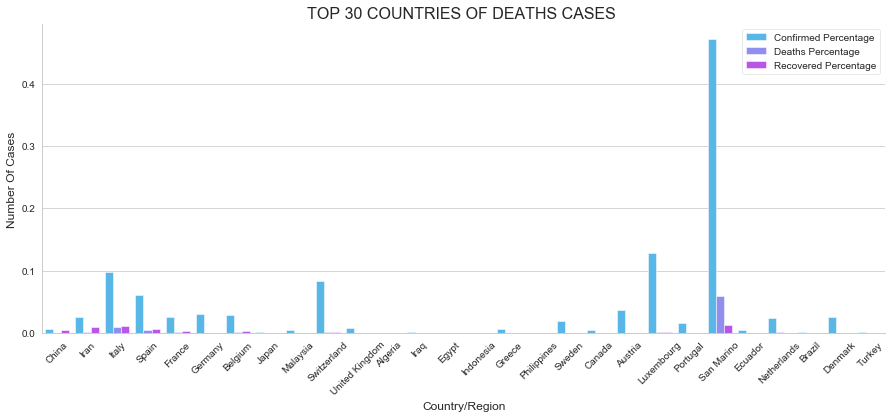

In [213]:
df9 = df7[df7['Country/Region'].isin(top_deaths_list) ]
df9.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df9, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='cool', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF DEATHS CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [214]:
# df8_population = df_2020[df_2020['Location'].isin(top_confirmed_list)]
# df8_population.head()

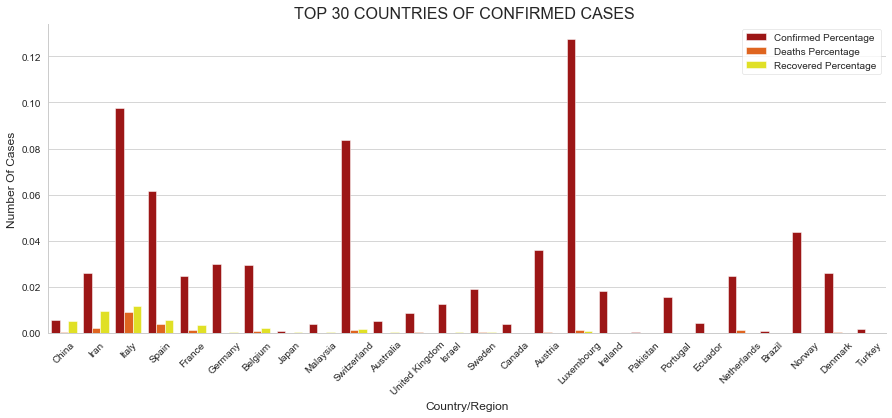

In [215]:
sns.set_style('whitegrid')
g = sns.catplot(data=df8, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='hot', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF CONFIRMED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [216]:
# df10_population = df_2020[df_2020['Location'].isin(top_recovered_list)]
# df10_population.head()

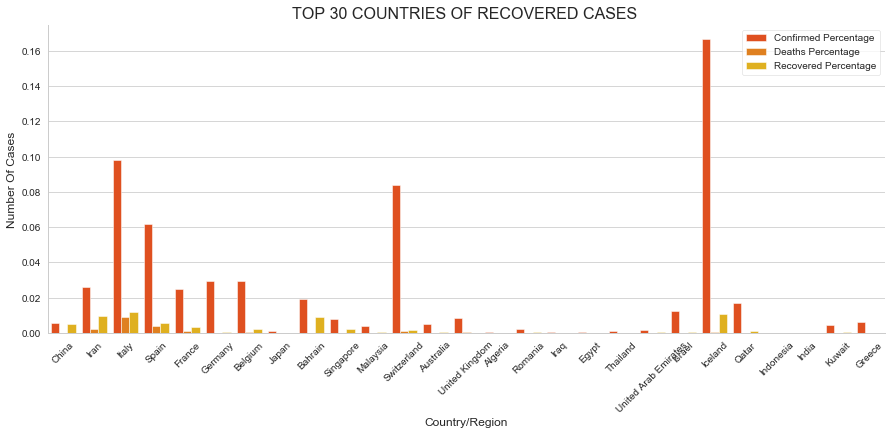

In [217]:
df10 = df7[df7['Country/Region'].isin(top_recovered_list) ]
df10.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df10, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='autumn', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF RECOVERED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [218]:
# top30_recovered.reset_index(inplace = True)
# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_recovered', data=top30_recovered,
#                 kind='bar', palette='autumn', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

### STEP 5: RESHAPE FROM WIDE TO LONG FORMAT

In [219]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['Country/Region'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [220]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for country in df['Country/Region']:
        melted = melt_data(df.loc[df['Country/Region'] == country])
        row = df.loc[df['Country/Region'] == country].iloc[:,:1]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [221]:
sorted_df_confirmed.reset_index(inplace=True)

In [222]:
sorted_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        1        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       4       4   
1       0       0       0       0       0       0       0       0       2   
2       1       3       5      12      12      17      17      19      20   
3       0       1       1       1       1       1       1       1       1   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        5        7        7        7       11       16       21       22   
1       10       12       23       33       38       42       51       55   
2       20       20       24       26       37       48       54       60   
3        1        1        1        1        1        1        2       39   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  
0       22       22       24       24       40  
1       59       64       70       76       89  
2       74       87       90      139      201  
3       39       53       75       88      113  
4        0        0        1        2        2

In [223]:
df = melt_df(sorted_df_confirmed)

In [224]:
df.head()

Country/Region       time  value
0    Afghanistan 2020-01-22      0
1    Afghanistan 2020-01-23      0
2    Afghanistan 2020-01-24      0
3    Afghanistan 2020-01-25      0
4    Afghanistan 2020-01-26      0

In [225]:
# check any columns has na/nan value, if there is missing data
#### forward fill missing value
#df['time'] = df['time'].ffill()
df.isnull().any()

Country/Region    False
time              False
value             False
dtype: bool

#### Convert to Time Series Data by setting the time column as the index

In [226]:
# make it as time series
df.set_index('time', inplace=True)

In [227]:
# look at the head again
df.head()

Country/Region  value
time                            
2020-01-22    Afghanistan      0
2020-01-23    Afghanistan      0
2020-01-24    Afghanistan      0
2020-01-25    Afghanistan      0
2020-01-26    Afghanistan      0

In [228]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Country/Region    False
value             False
dtype: bool

#### Now we see no more missing value in any column. Change the name of feature. Take a look at the final dataframe before performing EDA

In [229]:
# rename columns
df.rename(columns={'Country/Region': 'Country'}, inplace=True)
df.head()

Country  value
time                          
2020-01-22  Afghanistan      0
2020-01-23  Afghanistan      0
2020-01-24  Afghanistan      0
2020-01-25  Afghanistan      0
2020-01-26  Afghanistan      0

In [230]:
df.tail()

Country  value
time                       
2020-03-18  Zimbabwe      0
2020-03-19  Zimbabwe      0
2020-03-20  Zimbabwe      1
2020-03-21  Zimbabwe      3
2020-03-22  Zimbabwe      3

In [231]:
df

Country  value
time                                   
2020-01-22           Afghanistan      0
2020-01-23           Afghanistan      0
2020-01-24           Afghanistan      0
2020-01-25           Afghanistan      0
2020-01-26           Afghanistan      0
2020-01-27           Afghanistan      0
2020-01-28           Afghanistan      0
2020-01-29           Afghanistan      0
2020-01-30           Afghanistan      0
2020-01-31           Afghanistan      0
2020-02-01           Afghanistan      0
2020-02-02           Afghanistan      0
2020-02-03           Afghanistan      0
2020-02-04           Afghanistan      0
2020-02-05           Afghanistan      0
2020-02-06           Afghanistan      0
2020-02-07           Afghanistan      0
2020-02-08           Afghanistan      0
2020-02-09           Afghanistan      0
2020-02-10           Afghanistan      0
2020-02-11           Afghanistan      0
2020-02-12           Afghanistan      0
2020-02-13           Afghanistan      0
2020-02-14           Afghanistan      0
2020-02-15           Afghanistan      0
2020-02-16           Afghanistan      0
2020-02-17           Afghanistan      0
2020-02-18           Afghanistan      0
2020-02-19           Afghanistan      0
2020-02-20           Afghanistan      0
2020-02-21           Afghanistan      0
2020-02-22           Afghanistan      0
2020-02-23           Afghanistan      0
2020-02-24           Afghanistan      1
2020-02-25           Afghanistan      1
2020-02-26           Afghanistan      1
2020-02-27           Afghanistan      1
2020-02-28           Afghanistan      1
2020-02-29           Afghanistan      1
2020-03-01           Afghanistan      1
2020-03-02           Afghanistan      1
2020-03-03           Afghanistan      1
2020-03-04           Afghanistan      1
2020-03-05           Afghanistan      1
2020-03-06           Afghanistan      1
2020-03-07           Afghanistan      1
2020-03-08           Afghanistan      4
2020-03-09           Afghanistan      4
2020-03-10           Afghanistan      5
2020-03-11           Afghanistan      7
2020-03-12           Afghanistan      7
2020-03-13           Afghanistan      7
2020-03-14           Afghanistan     11
2020-03-15           Afghanistan     16
2020-03-16           Afghanistan     21
2020-03-17           Afghanistan     22
2020-03-18           Afghanistan     22
2020-03-19           Afghanistan     22
2020-03-20           Afghanistan     24
2020-03-21           Afghanistan     24
2020-03-22           Afghanistan     40
2020-01-22               Albania      0
2020-01-23               Albania      0
2020-01-24               Albania      0
2020-01-25               Albania      0
2020-01-26               Albania      0
2020-01-27               Albania      0
2020-01-28               Albania      0
2020-01-29               Albania      0
2020-01-30               Albania      0
2020-01-31               Albania      0
2020-02-01               Albania      0
2020-02-02               Albania      0
2020-02-03               Albania      0
2020-02-04               Albania      0
2020-02-05               Albania      0
2020-02-06               Albania      0
2020-02-07               Albania      0
2020-02-08               Albania      0
2020-02-09               Albania      0
2020-02-10               Albania      0
2020-02-11               Albania      0
2020-02-12               Albania      0
2020-02-13               Albania      0
2020-02-14               Albania      0
2020-02-15               Albania      0
2020-02-16               Albania      0
2020-02-17               Albania      0
2020-02-18               Albania      0
2020-02-19               Albania      0
2020-02-20               Albania      0
2020-02-21               Albania      0
2020-02-22               Albania      0
2020-02-23               Albania      0
2020-02-24               Albania      0
2020-02-25               Albania      0
2020-02-26               Albania      0
2020-02-27               Albania      0
2020-02-28               

# Step 2: EDA and Visualization

#### Visualization of data at a glance, just to see the whole picture of corona virus spreading.

In [232]:
# countries affected
countries = df['Country'].unique()
len(countries)

171

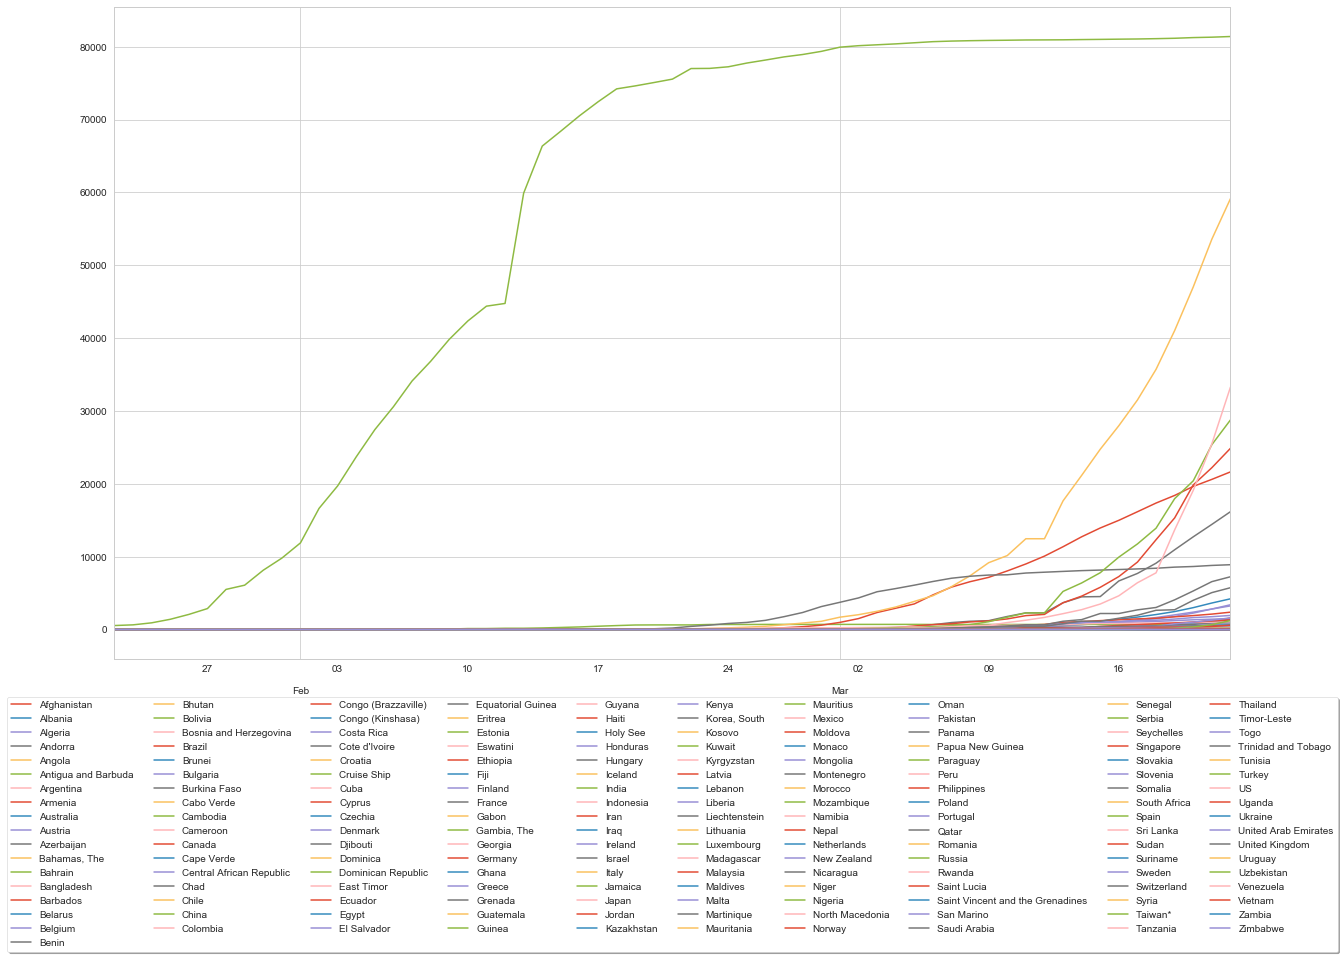

In [233]:
plt.figure(figsize=(20,12))

for c in countries:
    df[df['Country']==c]['value'].plot(label=c)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=10)
plt.show()

### From a quick plot above, we see that the corona virus had started and spreaded widely from China since Jan 22, 2020. There are some countries had started slightly from Feb 20 and the corona virus were actually growing much faster over time. Jan 26, 2020 the spreading speed has increased significantly in some countries such as Singapore, Spain, Iran, Italy . Mar 10, 2020 the corona virus has been spreading out crazily in other countries while there is no new confirmed case. 

#### Run an ETS Decomposition

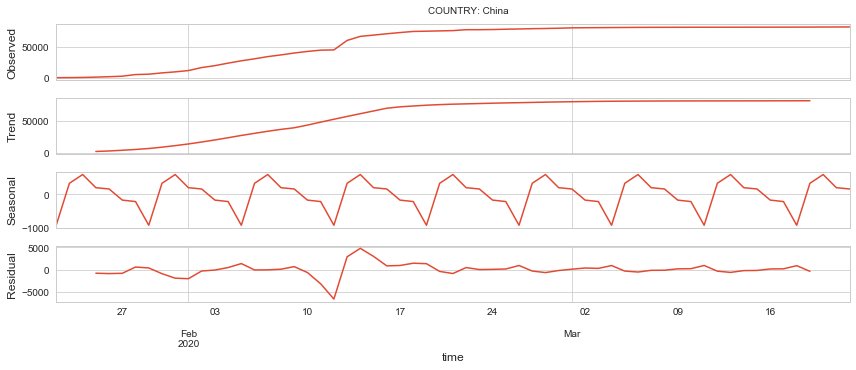

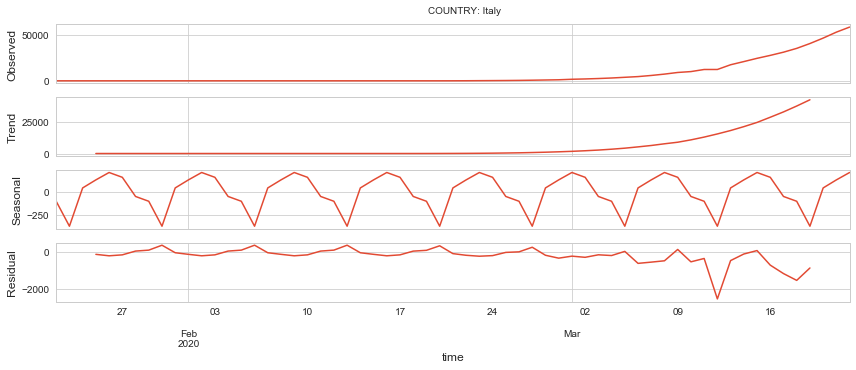

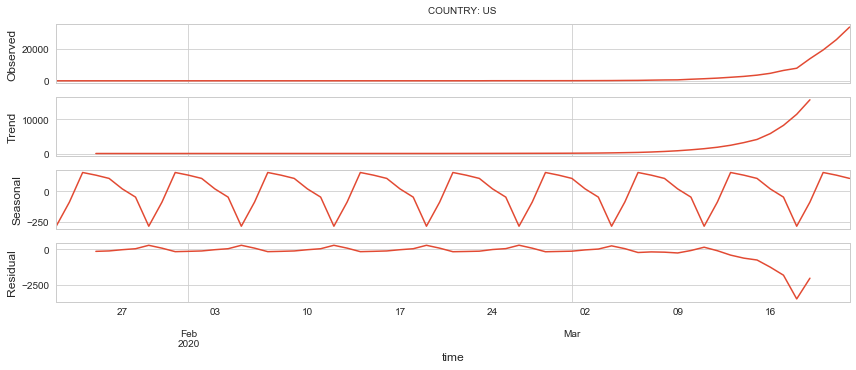

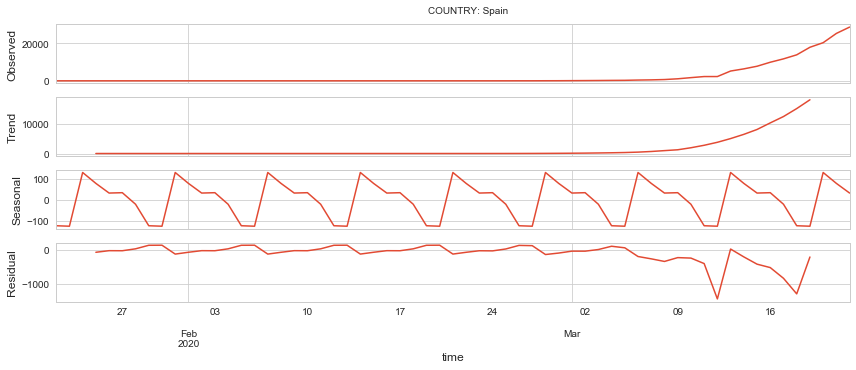

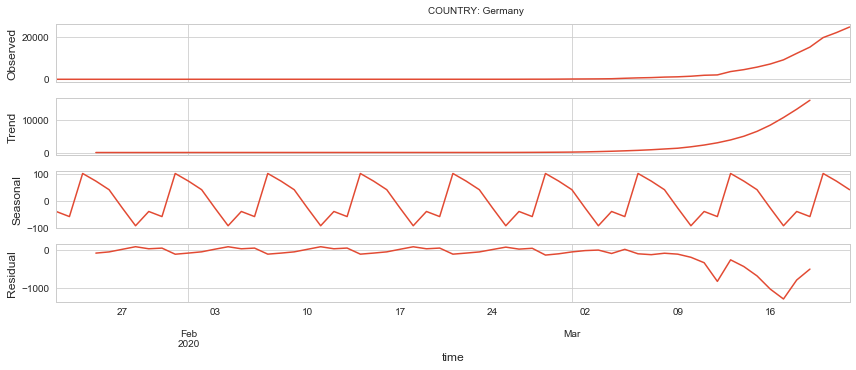

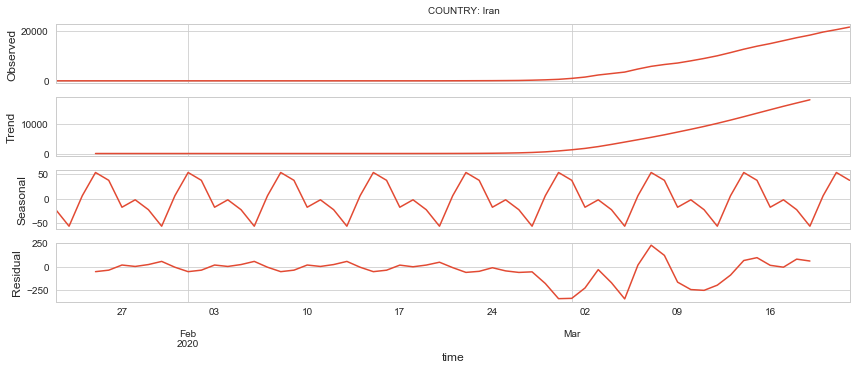

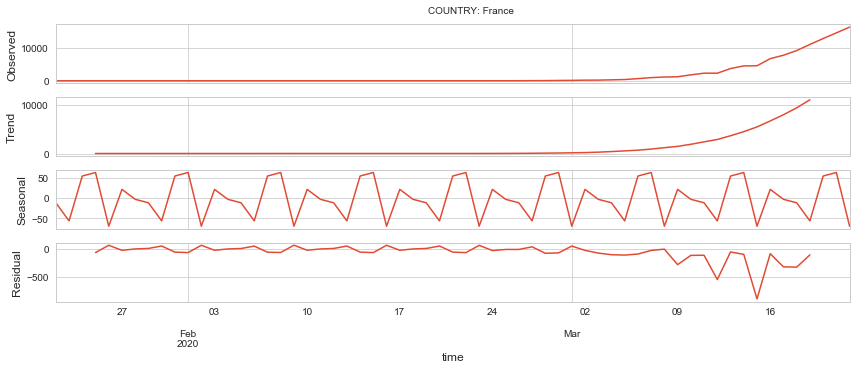

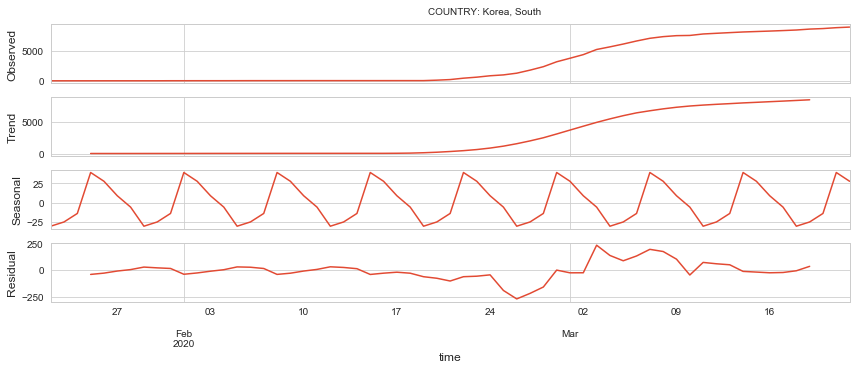

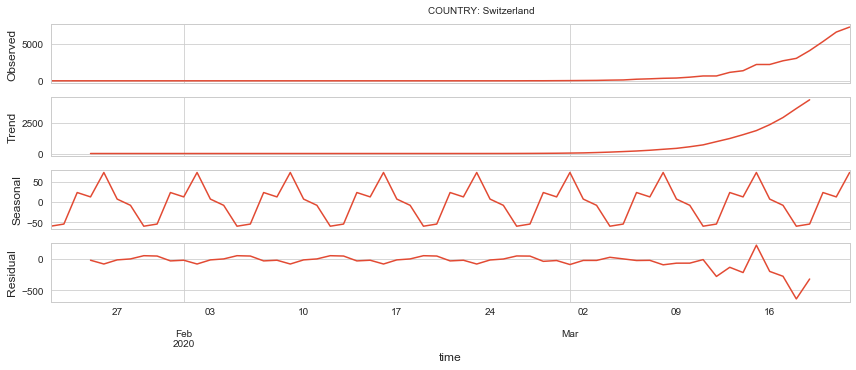

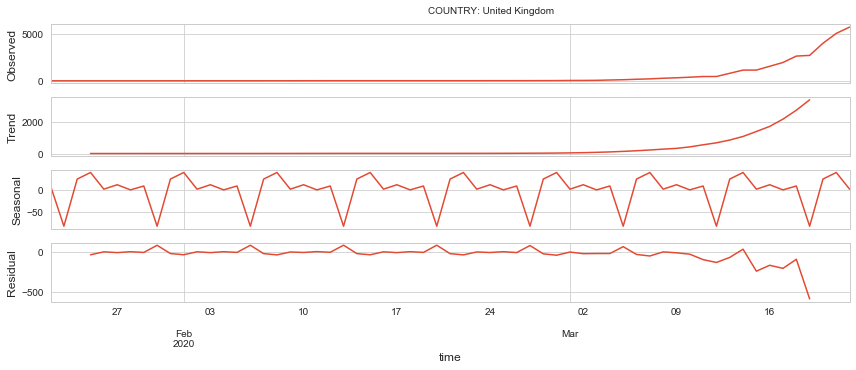

In [243]:
rcParams['figure.figsize'] = 12,5

for country in top_confirmed_list[0:10]:
    results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
    fig = results.plot();
    fig.text(0.5, 1, f'COUNTRY: {country}')

#### Plot ACF and PACF of some zipcodes to check corelation

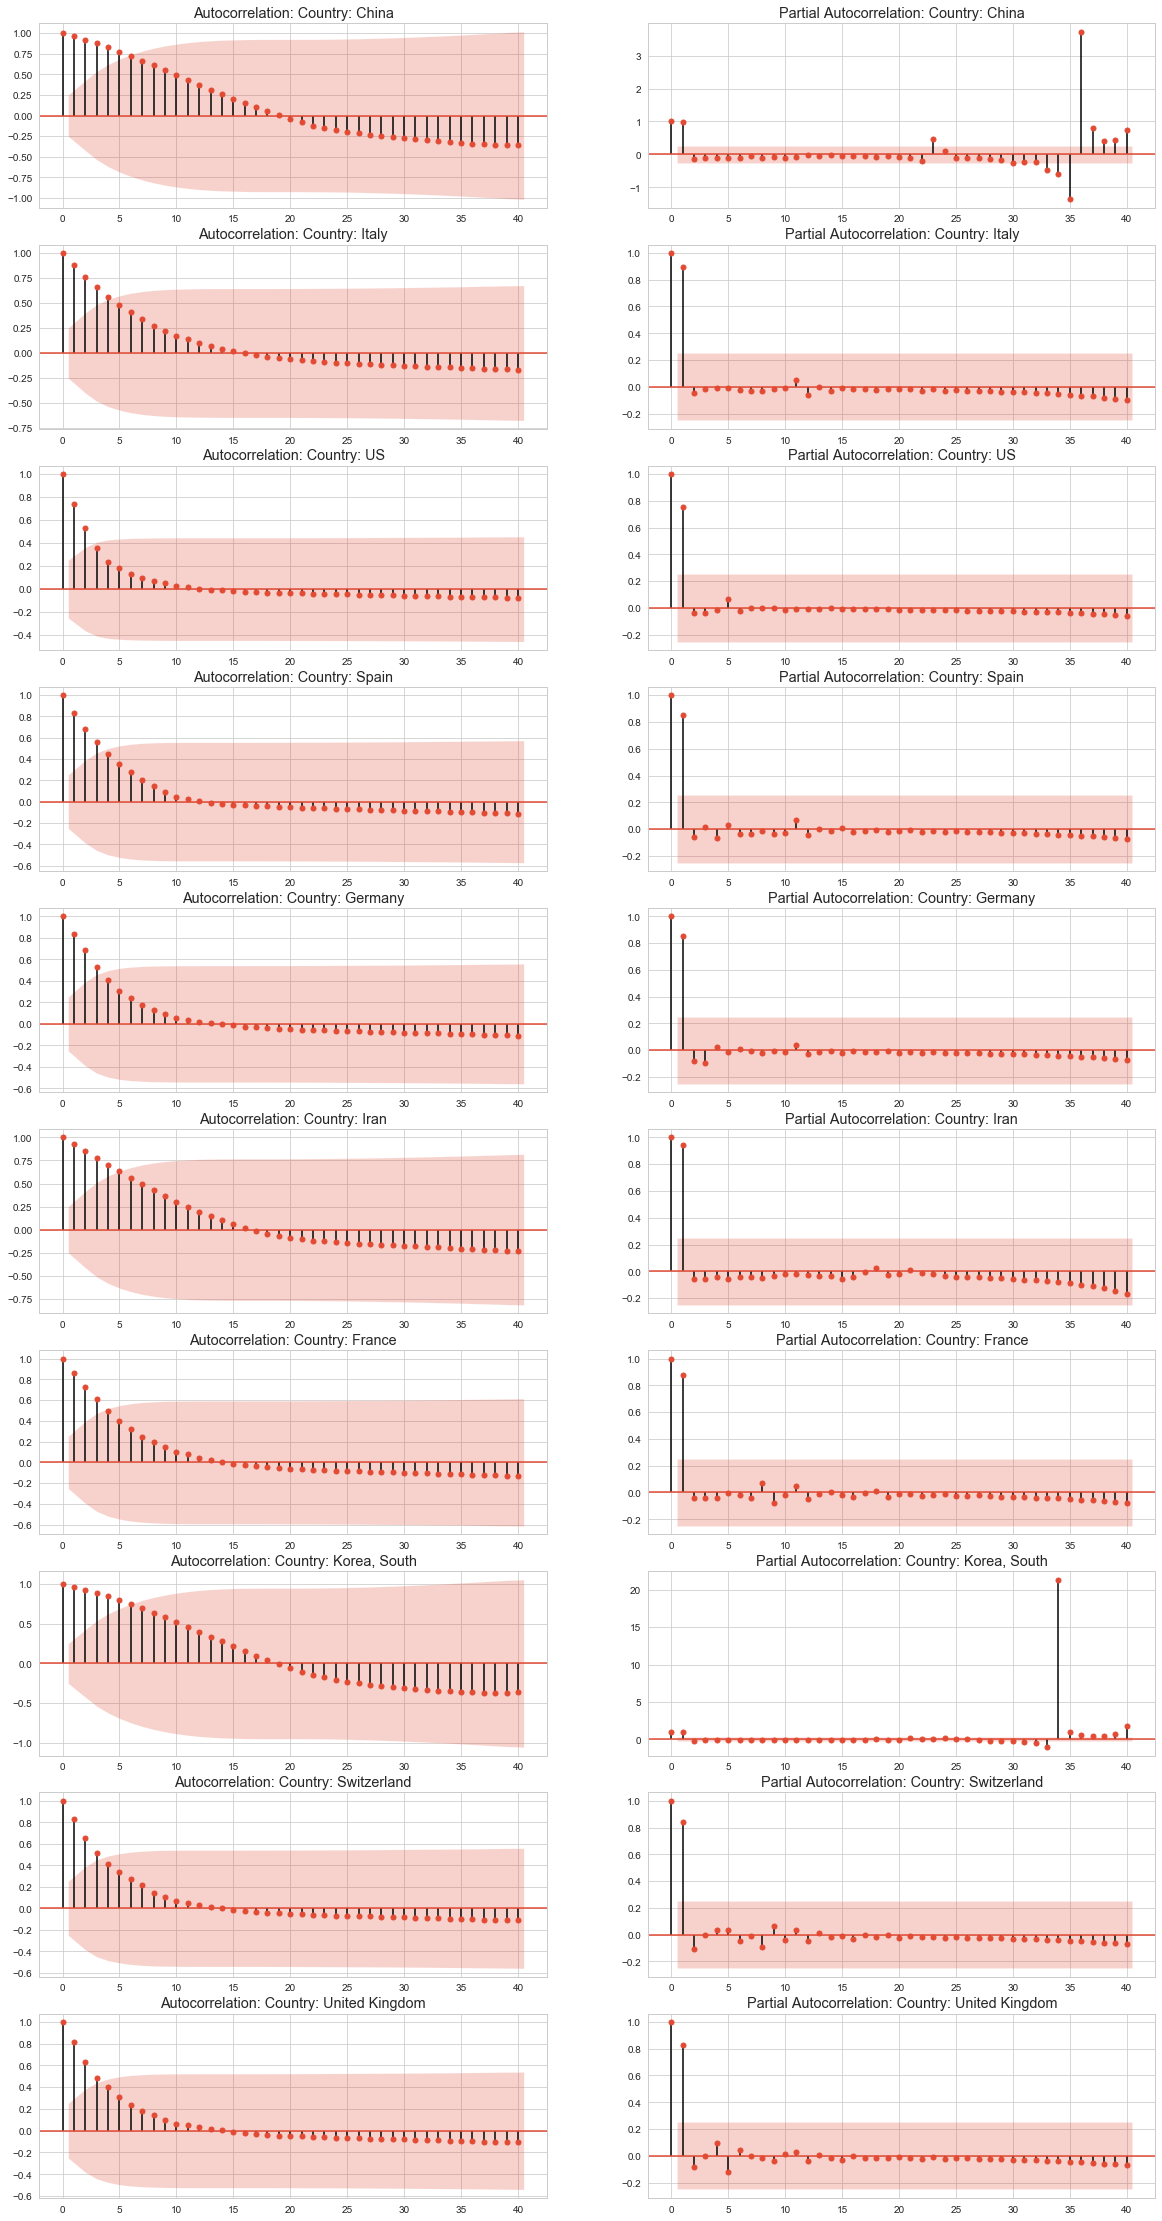

In [245]:
fig = plt.figure(figsize=(20,40))
i = 0
lags=40
for country in top_confirmed_list[0:10]:
    i += 1
    ax = plt.subplot(10,2,i)
    title = f'Autocorrelation: Country: {country}'
    plot_acf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

    i += 1
    ax = plt.subplot(10,2,i)
    title=f'Partial Autocorrelation: Country: {country}'
    plot_pacf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

## Automate the Augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [247]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print("==============================================================")
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print("--------------------------------------------------------------")
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("--------------------------------------------------------------")

In [249]:
# check ADF test for some zipcodes
for country in top_confirmed_list[0:10]:
    adf_test(df.loc[df['Country'] == country].value, title= f'COUNTRY: {country}')

Augmented Dickey-Fuller Test: COUNTRY: China
--------------------------------------------------------------
ADF test statistic      -2.300223
p-value                  0.171896
# lags used              1.000000
# observations          59.000000
critical value (1%)     -3.546395
critical value (5%)     -2.911939
critical value (10%)    -2.593652
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
--------------------------------------------------------------
Augmented Dickey-Fuller Test: COUNTRY: Italy
--------------------------------------------------------------
ADF test statistic      -3.136424
p-value                  0.023972
# lags used             11.000000
# observations          49.000000
critical value (1%)     -3.571472
critical value (5%)     -2.922629
critical value (10%)    -2.599336
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--------------

### With the Augmented Dickey-Fuller Test results, all data for all zipcodes are non-staytionary. except Italy

# STEP 8: Explore ARIMA Modeling to Find Best Fit Model

### Use grid search to find best fit ARIMA model of one sample country

In [250]:
# One sample test zipcode
country = top_confirmed_list[0]
country

'China'

In [251]:
# test with one zipcode
result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   59
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -533.407
Method:                       css-mle   S.D. of innovations           2029.780
Date:                Mon, 23 Mar 2020   AIC                           1072.814
Time:                        13:12:42   BIC                           1079.046
Sample:                             2   HQIC                          1075.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9263     77.939     -0.153      0.879    -164.683     140.831
ma.L1.D2.y    -0.7192      0.101     -7.098      0.000      -0.918      -0.521
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3904           +0.0000j            1.3904            0.0000
-----------------------------------------------------------------------------
"""

### After having the best-fit model from auto_arima grid search, we double check with visualization of ETS decomposition and ACF and PACF

Text(0.5, 1, 'COUNTRY: China')

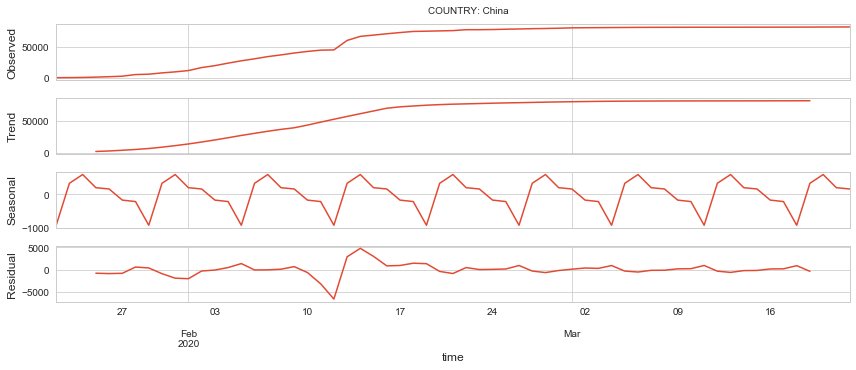

In [252]:
rcParams['figure.figsize'] = 12,5
results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
fig = results.plot();
fig.text(0.5,1,f'COUNTRY: {country}')

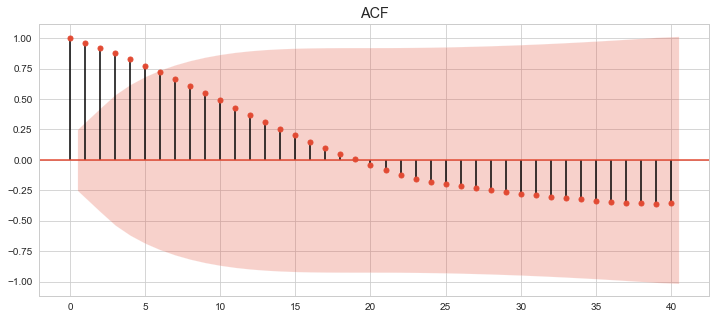

In [253]:
plot_acf(df.loc[df['Country'] == country].value,alpha=0.05,title='ACF',lags=40);

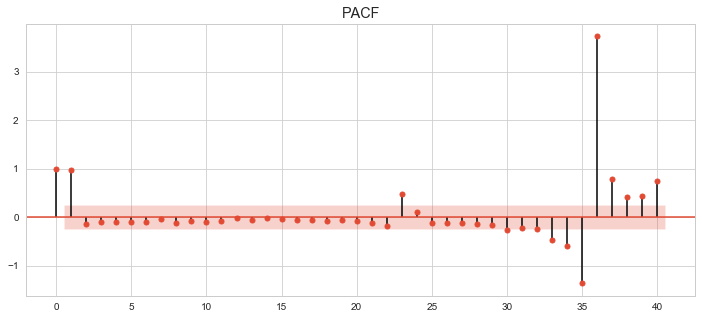

In [254]:
plot_pacf(df.loc[df['Country'] == country].value,alpha=0.05,title='PACF',lags=40);

#### Again, the ACF & PACF plots confirm the zipcode has none seasonality.

### Now, we wrote code to find best-fit models for a list of countries and store the fitted models in to a DataFrame for later dispaly and use
#### For quick testing purpose we only need to test with one country, but we can do for all countries

In [255]:
# find the best fit model for the first test zipcode
models = []
for country in top_confirmed_list[0:1]:
    result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    if result._is_seasonal():
        model = {'Country': country, 'model': 'SARIMAX', 'order': result.order,
                                     'seasonal_order': result.seasonal_order}
    else:
        model = {'Country': country, 'model': 'ARIMA', 'order': result.order, 
                                     'seasonal_order': None}
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

zipcode  model      order seasonal_order
0      NaN  ARIMA  (0, 2, 1)           None

#### After having the model, we split data of this country into train/test dataset to evaluate the accurateness of the model

In [256]:
first_country_data = df[df['Country']==country]
first_country_data.head()

Country  value
time                     
2020-01-22   China    548
2020-01-23   China    643
2020-01-24   China    920
2020-01-25   China   1406
2020-01-26   China   2075

In [257]:
# get tail data of 3 year - test data set
first_country_data.tail(36)

Country  value
time                     
2020-02-16   China  70513
2020-02-17   China  72434
2020-02-18   China  74211
2020-02-19   China  74619
2020-02-20   China  75077
2020-02-21   China  75550
2020-02-22   China  77001
2020-02-23   China  77022
2020-02-24   China  77241
2020-02-25   China  77754
2020-02-26   China  78166
2020-02-27   China  78600
2020-02-28   China  78928
2020-02-29   China  79356
2020-03-01   China  79932
2020-03-02   China  80136
2020-03-03   China  80261
2020-03-04   China  80386
2020-03-05   China  80537
2020-03-06   China  80690
2020-03-07   China  80770
2020-03-08   China  80823
2020-03-09   China  80860
2020-03-10   China  80887
2020-03-11   China  80921
2020-03-12   China  80932
2020-03-13   China  80945
2020-03-14   China  80977
2020-03-15   China  81003
2020-03-16   China  81033
2020-03-17   China  81058
2020-03-18   China  81102
2020-03-19   China  81156
2020-03-20   China  81250
2020-03-21   China  81305
2020-03-22   China  81397

In [ ]:
start_date = datetime(2020, 1, 22)
end_date = now
delta = end_date - start_date
train_days = round(delta.days * 0.7)
split_date = train_days + 1

In [274]:
# split train/test data
train_df = first_country_data.iloc[:train_days]
test_df = first_country_data.iloc[split_date:]
# split train/test data
#train_df = first_country_data.loc[:'2020-03-07']
#test_df = first_country_data.loc['2020-03-08':]

In [275]:
train_df.tail()

Country  value
time                     
2020-03-03   China  80261
2020-03-04   China  80386
2020-03-05   China  80537
2020-03-06   China  80690
2020-03-07   China  80770

In [276]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46 entries, 2020-01-22 to 2020-03-07
Data columns (total 2 columns):
Country    46 non-null object
value      46 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [277]:
test_df

Country  value
time                     
2020-03-08   China  80823
2020-03-09   China  80860
2020-03-10   China  80887
2020-03-11   China  80921
2020-03-12   China  80932
2020-03-13   China  80945
2020-03-14   China  80977
2020-03-15   China  81003
2020-03-16   China  81033
2020-03-17   China  81058
2020-03-18   China  81102
2020-03-19   China  81156
2020-03-20   China  81250
2020-03-21   China  81305
2020-03-22   China  81397

In [278]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2020-03-08 to 2020-03-22
Data columns (total 2 columns):
Country    15 non-null object
value      15 non-null int64
dtypes: int64(1), object(1)
memory usage: 360.0+ bytes


In [280]:
# fit the best model with full historical data for one test zipcode
model_data = model_df.iloc[0]
arima_model = sm.tsa.statespace.SARIMAX(train_df['value'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

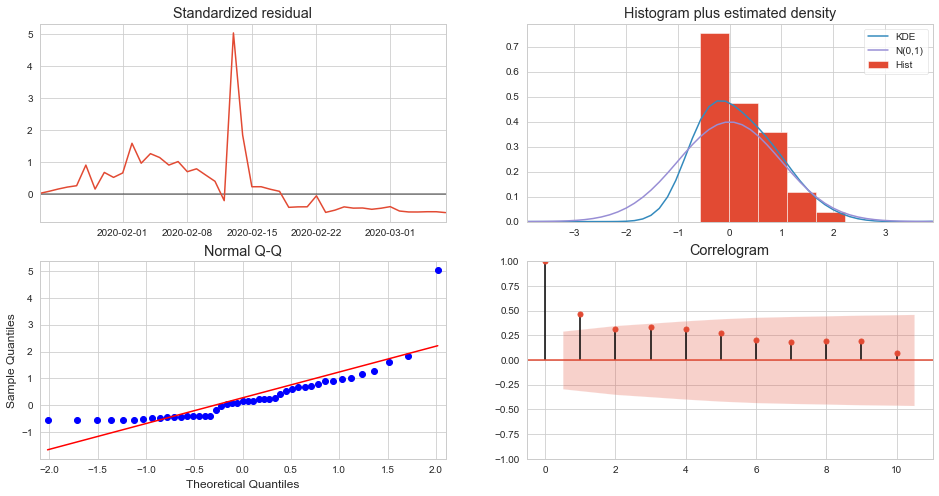

In [281]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Predict value for the next 2 months

In [282]:
# forecast into the future
start_date = pd.to_datetime('2020-03-22')
end_date = pd.to_datetime('2020-05-22')
forecast_values = fitted_model.predict(start=start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

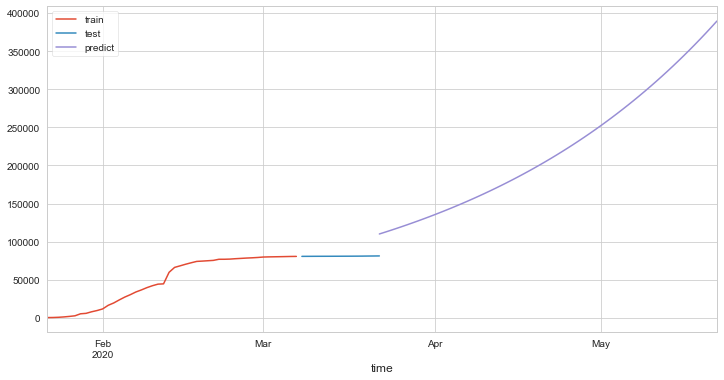

In [284]:
# plot historical and forecasted data
train_df['train'] = train_df['value']
train_df['train'].plot(legend=True,figsize=(12,6))
test_df['test'] = test_df['value']
test_df['test'].plot(legend=True)
forecast_values.plot(legend=True);


##### Compare in 3 bar graphs, top30 of current_cases, top30 of current_deaths, top30 of current_recovered.
##### Each graph has 3 color bars show data of 3 current information

### STEP 8: USE ARIMA TO PREDICT TIME SERIES DATA
#### Since we don't have enough data to check if it has seasonal trend  therefore we don't have to check seasonal trend.

### STEP 9: DEEP LEARNING - CONVOLUTIONAL NEURAL NETWORK (CNN) - TO PREDICT

### STEP 10: 

In [289]:
current_date = pd.to_datetime('today')
current_date

Timestamp('2020-03-23 13:46:39.668931')

In [304]:
from datetime import datetime, timedelta
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
print("current_date:",current_date)

current_date: 2020-03-23


In [321]:
# split train/test data
train_df = first_country_data.iloc[:train_days]
test_df = first_country_data.iloc[split_date:]

In [325]:
start_date = datetime(2020, 1, 22)
end_date = now
delta = end_date - start_date
train_days = round(delta.days * 0.7)
split_date = train_days + 1

43
44
